# Setting up

In [1]:
import pandas as pd
from bson.objectid import ObjectId
# Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colors import hex2color, rgb2hex,LinearSegmentedColormap, ListedColormap
import seaborn as sns
import datetime
import json
import numpy as np
from scipy import stats
#import networkx as nx
import os
import random
#from causalimpact import CausalImpact
#from sklearn.preprocessing import normalize

In [2]:
# Main color for the plot
main_color_hex = '#1b1c3a'
main_color = hex2color(main_color_hex)
second_color_hex = '#ffcc03'
second_color = hex2color(second_color_hex)
third_color_hex = '#1c3a1b'
third_color = hex2color(third_color_hex)

colors = [main_color, 'white', second_color] # first color is black, last is red
#colors = [main_color, second_color] # first color is black, last is red

edmo_divert = LinearSegmentedColormap.from_list(
        "EDMO_divert", colors, N=40)
edmo_cat = ListedColormap(edmo_divert(np.linspace(0, 1, 15)), N=17)
edmo_cat.name = 'EDMO_cat'
mpl.colormaps.register(edmo_divert)
mpl.colormaps.register(edmo_cat)

sns_color_palette_cat = sns.color_palette('tab20')
#sns_color_palette_cat = sns.color_palette('EDMO_divert')
sns.set_style("white")
# Size of the figure to match the latex document

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "figure.figsize" : (4.5, 4),
    "font.size":    12.0,
    'legend.fontsize' : 8,
    'xtick.labelsize' : 9,
    'ytick.labelsize' : 9

})


In [3]:
sns_color_palette_cat = sns.color_palette('EDMO_divert', 10)#[::-1]
random.seed(3120)
random.shuffle(sns_color_palette_cat)
sns_color_palette_cat

[(1.0, 0.9025641025641026, 0.518552036199095),
 (0.4268476621417798, 0.42936148818501757, 0.5047762694821518),
 (0.24343891402714934, 0.24675716440422324, 0.3463046757164404),
 (1.0, 0.8307692307692308, 0.16380090497737554),
 (0.7478129713423831, 0.7489190548014077, 0.7821015585721468),
 (0.9312217194570136, 0.9315233785822021, 0.9405731523378582),
 (0.5644042232277526, 0.5663147310206134, 0.6236299648064354),
 (1.0, 0.9435897435897437, 0.721266968325792),
 (1.0, 0.9846153846153847, 0.9239819004524887),
 (1.0, 0.8717948717948718, 0.3665158371040723)]

In [4]:
sns_color_palette_cat_20 = sns.color_palette('EDMO_divert', 20)#[::-1]
random.seed(3120)
random.shuffle(sns_color_palette_cat_20)
sns_color_palette_cat_20

[(1.0, 0.8102564102564103, 0.06244343891402715),
 (0.4268476621417798, 0.42936148818501757, 0.5047762694821518),
 (1.0, 0.9538461538461539, 0.771945701357466),
 (0.5185520361990951, 0.5206636500754147, 0.5840120663650076),
 (0.7019607843137254, 0.7032679738562091, 0.7424836601307189),
 (0.33514328808446453, 0.3380593262946204, 0.4255404725992961),
 (0.1517345399698341, 0.15545500251382605, 0.2670688788335847),
 (0.6102564102564102, 0.611965811965812, 0.6632478632478632),
 (0.24343891402714934, 0.24675716440422324, 0.3463046757164404),
 (0.7936651583710407, 0.7945701357466062, 0.8217194570135746),
 (0.9770739064856712, 0.9771744595274006, 0.980191050779286),
 (1.0, 0.9128205128205128, 0.5692307692307692),
 (0.8853695324283559, 0.8858722976370035, 0.9009552538964304),
 (1.0, 0.9743589743589743, 0.8733031674208145),
 (1.0, 0.8923076923076924, 0.46787330316742093),
 (1.0, 0.8512820512820514, 0.26515837104072393),
 (1.0, 0.8307692307692308, 0.16380090497737554),
 (1.0, 0.9333333333333333, 0.6705882352941177),
 (1.0, 0.9948717948717949, 0.9746606334841629),
 (1.0, 0.8717948717948718, 0.3665158371040723)]

In [5]:
# Mkdir folder for plots if not existing
folder_plots_eps = './plots/selected_plots/pdf/'
os.makedirs(folder_plots_eps, exist_ok=True)
folder_plots_png = './plots/selected_plots/png/'
os.makedirs(folder_plots_png, exist_ok=True)


eps_path = os.path.join(folder_plots_eps)
png_path = os.path.join(folder_plots_png)
os.makedirs(eps_path, exist_ok=True)
os.makedirs(png_path, exist_ok=True)

# Functions

In [6]:
def extract_value_from_dict(df, colname, val_pos):
    df_temp = pd.json_normalize(df[colname])
    df_temp = df_temp.applymap(lambda x: list(x.values())[val_pos] if isinstance(x, dict) else x)
    df_temp.columns = [f"{colname}_{x}" for x in df_temp.columns]
    df = df.drop(colname, axis=1)
    return pd.concat([df, df_temp], axis=1)

In [7]:
def extract_values(series, key):
    def extract(row):
        values = []
        for d in row:
            if key in d:
                values.append(d[key])
        return values
    return series.apply(extract)

In [8]:
def replace_values(df, value_maps):
    def replace_values_in_list(lst, value_map):
        return list(map(lambda x: value_map.get(x, x), lst))
    
    for col, value_map in value_maps.items():
        if isinstance(df[col].iloc[0], str):
            df[col] = df[col].replace(value_map)
        elif isinstance(df[col].iloc[0], list):
            df[col] = df[col].apply(replace_values_in_list, args=(value_map,))
    
    return df

In [9]:
def define_colours(df, column, color_palette=None):
    if color_palette is None:
        color_palette = sns_color_palette_cat
    # Define the colour for the different categorical variables to be coherent
    colours= dict()
    df = df.explode(column)

    for i, j in enumerate(np.sort(df[column].unique())):
        colours[j] = plt.cm.colors.to_rgba(color_palette[i])
    return colours


def get_values_count(df, column):
    df = df.explode(column)
    df_counts = df[column].value_counts(normalize=False).to_frame().reset_index().set_axis([column, 'Counts'],  axis=1)
    df_counts['Percentages'] = df[column].value_counts(normalize=True).values*100
    df_counts['Percentages'] = df_counts['Percentages'].apply(lambda x: round(x, 1))
    return df_counts


def output_df_for_cross(df, field1, field2, reorder_first=True, reorder_second=True):
    # Generate the groupby df 
    df = df.explode(field1)
    df = df.explode(field2)
    # Count the value and create a table
    df = df.groupby([field1, field2]).size().unstack(fill_value=0)
    # Reorder per first category
    if reorder_first is True:
        df = df.assign(tmp=df.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)
    # Reorder for the second category
    if reorder_second is True:
        df = df.transpose().assign(tmp=df.sum(axis=0)).sort_values('tmp', ascending=False).drop(labels='tmp', axis=1).transpose()
    # Normalised
    df_norm = df.div(df.sum(axis=1), axis=0)

    return df, df_norm

In [10]:
def plot_counts(df, column, color=main_color, kind_bar='bar', width_bar=0.9): 
                
    fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);    
    # In case of horizontal plot, reorder to avoid having the highest count at the bottom
    if kind_bar == 'barh':
        df = df.sort_values(by='Counts', ascending=True)   
    df.plot(kind=kind_bar, x=column, y='Counts', stacked=True,ax=ax, legend=None, width=width_bar, color=color)
    ax.set(xlabel= column)
    ax.set(ylabel='Count')
    ax.tick_params(rotation=0)
    filename = f'{column}'
    return filename, fig, ax


def plot_cross(df, field1, field2, colours, width_bar=1, norm=False, ax=None):

    if ax is None:
        fig, ax = plt.subplots(layout='constrained')
    if norm:
        sns.despine(offset=None, trim=False, left=True, bottom=True)
        filename = f"{field1}_{field2}_norm"
    else:
        sns.despine(offset=5, trim=False);
        filename = f"{field1}_{field2}"
    df.plot.barh(stacked=True, ax=ax, color= color_palette, width=width_bar, edgecolor=second_color, linewidth=0.3)
    ax.set(xlabel='Count')
    ax.set(ylabel=f'claims_{field1}')
    ax.tick_params(rotation=0)
    ax.get_legend().remove()
    return filename, ax


def plot_per_day(df, column, colours,  width_bar=0.9, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.despine(offset=5, trim=False);
    df.plot(kind='bar', ax=ax, stacked=True, color=colours, width=width_bar) 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.set(xlabel='Dates')
    ax.set(ylabel='Count')
    ax.tick_params(rotation=90)
    filename = f'claims_{column}_per_days'
    return filename, fig, ax



## Save plots

In [11]:
def save_plot(fig, ax, filename, sample, 
              half_sise=False, 
              png_size=None, eps_size=None, 
              legend=True, legend_position='outside lower center', ncol_legend=2):
    
    def despine(ax, color):
        try:
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
            ax.tick_params(axis='both', colors=color)
            ax.xaxis.label.set_color(color)
            ax.yaxis.label.set_color(color)
        except AttributeError:
            for axs in ax:
                despine(axs, color)
                
    def change_fontsize_ax(ax, fontsize):
        try:
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(fontsize)
        except AttributeError:
            for axs in ax:
                change_fontsize_ax(axs, fontsize)
                
                
                
    ########### Cleaning legend ###########        
    fig.legends = []
    try:
        ax.legend().remove()
    except AttributeError:
        for axs in ax:
            axs.legend().remove()

        ########### SAVING PNG ###########        
    if png_size:
        fig.set_size_inches(png_size)
    else:
        fig.set_size_inches(7, 7)
    despine(ax, 'grey')

    # Increase font size of everything
    fontsize = 16

    color_legend = 'grey'
    color_text = 'grey'
    
    change_fontsize_ax(ax, fontsize)
    if legend is True:
        # Remove duplicate labels from the legend
#         if isinstance(ax, np.ndarray):
#             for axs in ax:
#                 leg_temp = axs.legend()
#                 if leg_temp is not None:
#                     legend_ax = leg_temp
#                 axs.legend().remove()
                
        fontsize_legend = 15
        fig.legend(loc=legend_position, ncol=ncol_legend,  fontsize=fontsize_legend)

    
    fig.savefig(f'{folder_plots_png}/{sample}_{filename}.png', bbox_inches='tight', pad_inches=0.1, dpi=600)
  
    ########### Cleaning legend ###########        
    fig.legends = []
    try:
        ax.legend().remove()
    except AttributeError:
        for axs in ax:
            axs.legend().remove()

    
    ########### SAVING EPS ###########

    if eps_size:
        fig.set_size_inches(eps_size)
    else:
        fig.set_size_inches(4.5, 4.5)

    despine(ax, 'grey')
    fontsize = 12
    
    color_legend = 'grey'
    color_text = 'grey'
    
    change_fontsize_ax(ax, fontsize)

    if legend is True:
        # Remove duplicate labels from the legend in case of multiple ax
        # if isinstance(ax, np.ndarray):
        #     for axs in ax:
        #         leg_temp = axs.legend()
        #         if leg_temp is not None:
        #             legend_ax = leg_temp
        #         axs.legend().remove()
        fontsize_legend = 12
        fig.legend(loc=legend_position, ncol=ncol_legend,  fontsize=fontsize_legend)

    fig.savefig(f'{folder_plots_eps}/{sample}_{filename}.pdf', bbox_inches='tight', pad_inches=0.1, dpi=600)
    
    
    try:
        leg = ax.get_legend()
    except AttributeError:
        for axs in ax:
            leg = axs.get_legend()
            if leg is not None:
                break

  
 

# Loading and subsetting data

In [12]:
with open('../data/dumps/maldita.json', 'r') as f:
    json_iberifier = json.load(f)
df_iberifier = pd.json_normalize(json_iberifier)
df_iberifier['formats'] = extract_values(df_iberifier['formats'], 'name')
df_iberifier['sources'] = extract_values(df_iberifier['sources'], 'name')
df_iberifier['categories'] = extract_values(df_iberifier['categories'], 'name')
# Drop unused columns
to_drop = ['organization.id', 'debunkContent', 'media', 'keywords', 'organizationCalification.calification.id']
for col in to_drop:
    df_iberifier = df_iberifier.drop(col, axis=1)
    
# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'fact_id', 
               'type.name': 'type',
               'organization.name': 'fact_checker',
               'organizationCalification.calification.explanation': 'explanation', 
               'organizationCalification.calification.name': 'qualification',
               'date.$date': 'date'}
df_iberifier = df_iberifier.rename(columns=rename_cols)

#df_iberifier['date']

#new_col = pd.to_datetime(df_iberifier['date']).dt.date
#new_col
# Convert datetime object
df_iberifier['time'] = pd.to_datetime(df_iberifier['date'])
df_iberifier['date'] = pd.to_datetime(df_iberifier['date']).dt.date


# Replace some nan value with None is some column to avoid issues with np
df_iberifier['type'] = df_iberifier['type'].replace(to_replace=np.nan, value='None')


In [13]:
# Replacing the values
rename_fields ={'categories': {'Alertas': 'Alerts', 
                               'Terrorismo':'Terrorism', 
                               'Seguridad / Segurança': 'Security',
                               'Sexualidad / Sexualidade': 'Sexuality', 
                               'Religión / Religião': 'Religion', 
                               'Alimentación / Alimentação': 'Food', 
                               'Desastres medioambientales / ambientais': 'Enviromental disasters', 
                               'Migración/Migraçao - Racismo': 'Migration/Racism', 
                               'Consumo': 'Consume',   # Not great
                               'Género / Gênero': 'Gender', 
                               'Salud / Saúde': 'Health' , 
                               'Ciencia / Ciência ': 'Science', 
                               'Timo / Fraude': 'Fraud', 
                               'Otro / Outros': 'Others', 
                               'Personajes / Personagens': 'Personalities', 
                               'Política': 'Politics'},
                'sources': {'Otros / Outros': 'Others',
                            'Buscador' : 'Researcher'}, # Journalist?
                'qualification': {'Falso': 'False',
                                   'Verdadero / Verdadeiro': 'True',
                                   'No verificable / Não verificável': 'Not verifiable',
                                   'Manipulado': 'Manipulation',
                                   'Engañoso / Enganador': 'Propagande'},
                'type':{'Otros / Outros': 'Others',
                        'Timo / Fraude': 'Fraud',
                        'Contexto falso - Información / Informação falsa': 'Wrong context', # Not great
                        'Alerta falsa/falso': 'False alert',
                        'Cita falsa / Citação falsa': 'False citation',
                        'Contenido/Conteúdo manipulado': 'Manipulated content',
                        'Invent': 'Invention',
                        'Sátira': 'Satire'}
               }

In [14]:
df_iberifier = replace_values(df_iberifier, rename_fields)

In [15]:
with open('./../data/dumps/tweets.json', 'r') as f:
    json_tweets = json.load(f)
df_tweets = pd.json_normalize(json_tweets)
df_tweets['fact_id'] = extract_values(df_tweets['fact_id'], '$oid')

# Drop unused columns
to_drop = ['tweet.in_reply_to_user.withheld.scope', 'tweet.withheld.scope', 'tweet.attachments.poll_ids', 'tweet.author.withheld.scope']
for col in to_drop:
    df_tweets = df_tweets.drop(col, axis=1)

# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'db_id', 
               'date.$date': 'date', 
               'tweet.public_metrics.retweet_count': 'retweet_count',
               'tweet.public_metrics.like_count': 'like_count',
               'tweet.public_metrics.quote_count': 'quote_count',
               'tweet.public_metrics.impression_count': 'impression_count',
               'tweet.public_metrics.reply_count': 'reply_count'
              }

df_tweets = df_tweets.rename(columns=rename_cols)
# Convert datetime object
df_tweets['time'] = pd.to_datetime(df_tweets['date'])
df_tweets['date'] = pd.to_datetime(df_tweets['date']).dt.date


In [16]:
with open('./../data/dumps/mynews.json', 'r') as f:
    json_mynews = json.load(f)
df_mynews = pd.json_normalize(json_mynews)
# Rename some columns for easy viz
rename_cols = {'_id.$oid': 'db_id', 'date.$date': 'date', 'fact_id.$oid': 'fact_id'}
df_mynews = df_mynews.rename(columns=rename_cols)
# Convert datetime object
df_mynews['time'] = pd.to_datetime(df_mynews['date'])
df_mynews['date'] = pd.to_datetime(df_mynews['date']).dt.date

In [17]:
with open('./../data/dumps/keywords.json', 'r') as f:
    json_keywords = json.load(f)
df_keywords = pd.json_normalize(json_keywords)
rename_cols = {'_id.$oid': 'db_id', 'date.$date': 'date', 'fact_id.$oid': 'fact_id'}
df_keywords = df_keywords.rename(columns=rename_cols)

In [18]:
# Subsetting 

# EVAL 
## Iberifier
mask_eval_iberifier =  (df_iberifier['qualification'] == 'False') & (df_iberifier['fact_checker'].isin(['Maldita.es', 'EFE Verifica', 'Newtral']))
df_iberifier['experience_subset'] = mask_eval_iberifier
#### Get the list of valid fact_ids to mask the other sets
list_fact_id_eval = df_iberifier[df_iberifier['experience_subset'] == True]['fact_id'].to_list()

## Tweets
mask_tweets_eval = df_tweets['fact_id'].apply(lambda x: any(item in list_fact_id_eval for item in x))
df_tweets['experience_subset'] = mask_tweets_eval

## Mynews
mask_mynews_eval =  df_mynews['fact_id'].isin(list_fact_id_eval)
df_mynews['experience_subset'] = mask_mynews_eval

## Keywords
mask_keywords_eval =  df_keywords['fact_id'].isin(list_fact_id_eval)
df_keywords['experience_subset'] = mask_keywords_eval

# TOPIC_RELATION
## Tweets
mask_tweets_topic_relation = (df_tweets['topic_relation'].notnull()) & mask_tweets_eval
df_tweets['topic_relation_subset'] = mask_tweets_topic_relation

## Mynews
mask_mynews_topic_relation = df_mynews['topic_relation'].notnull() & mask_mynews_eval
df_mynews['topic_relation_subset'] = mask_mynews_topic_relation

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_topic_relation_tweets = df_tweets[df_tweets['topic_relation_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_topic_relation_mynews = df_mynews[df_mynews['topic_relation_subset'] == True]['fact_id'].to_list()
list_factids_topic_relation = list_factids_topic_relation_tweets + list_factids_topic_relation_mynews

mask_iberifier_topic_relation = df_iberifier['fact_id'].isin(list_factids_topic_relation)
df_iberifier['topic_relation_subset'] = mask_iberifier_topic_relation

# On-Topic
## Tweets
mask_tweets_on_topic = (df_tweets['topic_relation'] == 'on-topic') & mask_tweets_topic_relation
df_tweets['on_topic_subset'] = mask_tweets_on_topic
## Mynews
mask_mynews_on_topic = (df_mynews['topic_relation'] == 'on-topic') & mask_mynews_topic_relation
df_mynews['on_topic_subset'] = mask_mynews_on_topic

## Iberifier
### Getting the list of present fact_ids in mynews and tweets from topic_relation. For tweets they may be several fact_ids for one tweet
list_factids_on_topic_tweets = df_tweets[df_tweets['on_topic_subset'] ==True].explode('fact_id')['fact_id'].to_list()
list_factids_on_topic_mynews = df_mynews[df_mynews['on_topic_subset'] == True]['fact_id'].to_list()
list_factids_on_topic = list_factids_on_topic_tweets + list_factids_on_topic_mynews
mask_iberifier_on_topic = df_iberifier['fact_id'].isin(list_factids_on_topic)

df_iberifier['on_topic_subset'] = mask_iberifier_on_topic

# Plotting

# All - Overview of data collected

In [19]:
number_claims_all = len(df_iberifier.index)
number_claims_eval = len(df_iberifier[df_iberifier['experience_subset'] == True].index)
number_claims_topic_relation =  len(df_iberifier[df_iberifier['topic_relation_subset'] == True].index)
number_claims_on_topic = len(df_iberifier[df_iberifier['on_topic_subset'] == True].index)

number_tweets_all = len(df_tweets.index)
number_tweets_eval = len(df_tweets[df_tweets['experience_subset'] == True].index)
number_tweets_topic_relation = len(df_tweets[df_tweets['topic_relation_subset'] == True].index)
number_tweets_on_topic = len(df_tweets[df_tweets['on_topic_subset'] == True].index)

number_news_all = len(df_mynews.index)
number_news_eval = len(df_mynews[df_mynews['experience_subset'] == True].index)
number_news_topic_relation = len(df_mynews[df_mynews['topic_relation_subset'] == True].index)
number_news_on_topic = len(df_mynews[df_mynews['on_topic_subset'] == True].index)

all_count = [number_claims_all, number_news_all, number_tweets_all ]
eval_count = [number_claims_eval, number_news_eval, number_tweets_eval]
topic_relation_count = [number_claims_topic_relation, number_news_topic_relation, number_tweets_topic_relation]
on_topic_count = [number_claims_on_topic, number_news_on_topic,  number_tweets_on_topic]


# Add some descriptive stats for them 

# Average of tweets per claim



# Average of news articles per claim

## Descriptive table

In [20]:
datasources = ['Claims','News',  'Tweets' ]
df_overview = pd.DataFrame({'Data source': datasources, 'All': all_count, 'Eval':eval_count , 'Topic relation': topic_relation_count, 'On Topic': on_topic_count})#.set_index('Data source')
#filename, fig, ax = plot_counts(df_overview, 'Data source', kind_bar='bar')
df_overview

,Data source,All,Eval,Topic relation,On Topic
0,Claims,167,82,84,81
1,News,1391,1133,1133,637
2,Tweets,143327,96380,96380,14852


## Number of keywords

In [21]:
df_keywords['nbr_keywords'] = df_keywords['keywords'].apply(lambda x: len(x))
df_keywords['nbr_keywords'].describe()

count    162.000000
mean       5.753086
std        0.926234
min        5.000000
25%        5.000000
50%        6.000000
75%        6.000000
max       12.000000
Name: nbr_keywords, dtype: float64

## Fact checkers

,fact_checker,Counts,Percentages
0,Newtral,69,41.3
1,Maldita.es,53,31.7
2,Polígrafo,22,13.2
3,Verificat,14,8.4
4,EFE Verifica,9,5.4


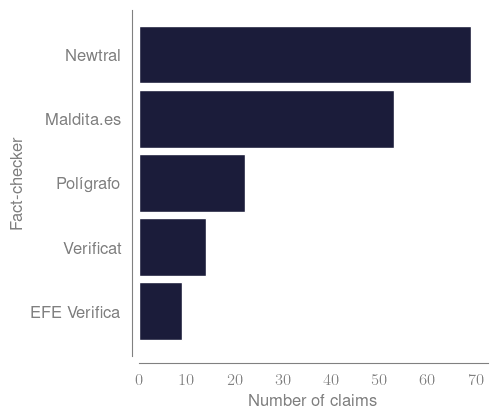

In [22]:
#mpl.rcParams.update(mpl.rcParamsDefault)

field = 'fact_checker'

# Define the colour for the fact-checker to be coherent
colours_fact_checker = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Fact-checker')
ax.set_xlabel('Number of claims')
#ax.tick_params(rotation=90)

## Save the plot
save_plot(fig, ax, filename, 'all', legend=False)

# Output the table
field_counts

## Qualification of claim

,qualification,Counts,Percentages
0,False,107,64.1
1,Explainer,24,14.4
2,True,20,12.0
3,Propagande,9,5.4
4,Not verifiable,4,2.4
5,Manipulation,3,1.8


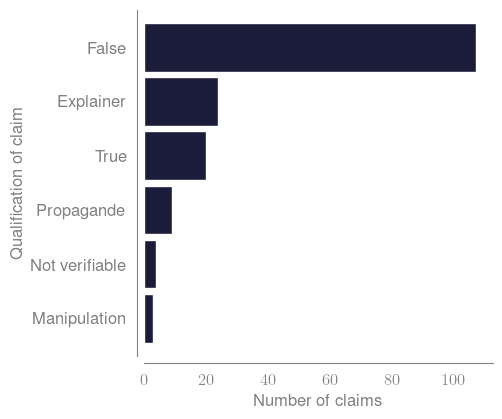

In [23]:
field = 'qualification'

# Define the colour for the fact-checker to be coherent
colours_qualification_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Qualification of claim')
ax.set_xlabel('Number of claims')

## Save the plot
save_plot(fig, ax, filename, 'all', legend=False)

# Output the table
field_counts

## Category of Claim

,categories,Counts,Percentages
0,Politics,61,23.3
1,Social,45,17.2
2,Personalities,25,9.5
3,Fraud,22,8.4
4,Others,18,6.9
5,Science,17,6.5
6,Migration/Racism,11,4.2
7,Gender,11,4.2
8,Health,10,3.8
9,Sexuality,9,3.4


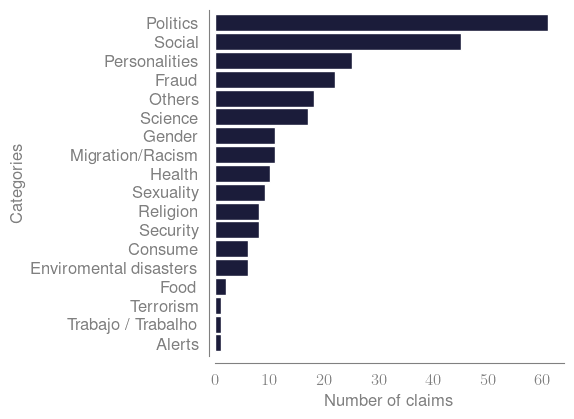

In [24]:
field = 'categories'

# Define the colour for the fact-checker to be coherent
colours_cat_claims = define_colours(df_iberifier, field, color_palette=sns_color_palette_cat_20)
# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Categories')
ax.set_xlabel('Number of claims')

## Save the plot
save_plot(fig, ax, filename, 'all', legend=False)

# Output the table
field_counts

## Sources

,sources,Counts,Percentages
0,Twitter,74,30.3
1,Facebook,66,27.0
2,Others,54,22.1
3,WhatsApp,21,8.6
4,TikTok,20,8.2
5,Telegram,4,1.6
6,Researcher,3,1.2
7,Instagram,2,0.8


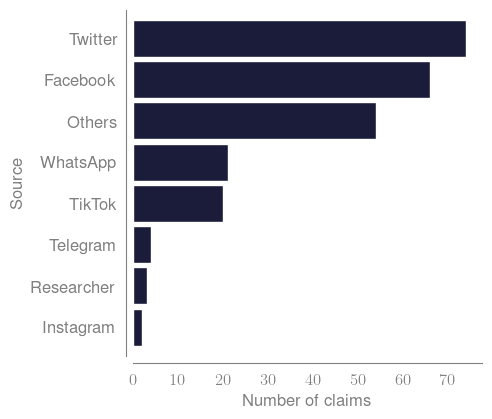

In [25]:
field = 'sources'

# Define the colour for the fact-checker to be coherent
colours_source_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Source')
ax.set_xlabel('Number of claims')

## Save the plot
save_plot(fig, ax, filename, 'all', legend=False)

# Output the table
field_counts

## Type

,type,Counts,Percentages
0,Wrong context,43,25.7
1,Others,37,22.2
2,Manipulated content,24,14.4
3,Invention,20,12.0
4,Fraud,17,10.2
5,False citation,13,7.8
6,None,9,5.4
7,False alert,4,2.4


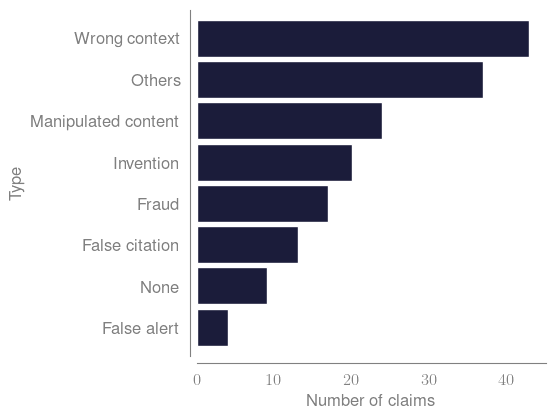

In [26]:
field = 'type'

# Define the colour for the fact-checker to be coherent
colours_type_claims = define_colours(df_iberifier, field)

# Get the counts
field_counts = get_values_count(df_iberifier, field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier, 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Type')
ax.set_xlabel('Number of claims')

## Save the plot
save_plot(fig, ax, filename, 'all', legend=False)

# Output the table
field_counts

## Fact checker and Qualification of claims

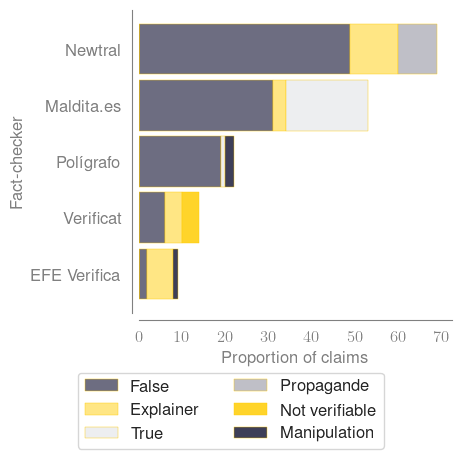

In [27]:
# Setting up the variable for the plot
field1 = 'fact_checker'
field2 = 'qualification'
color_palette = colours_qualification_claims
df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)
fig, ax = plt.subplots(layout='constrained')
# Generating the plot
filename, ax = plot_cross(df_to_plot, field1, field2, color_palette,  width_bar=0.9, norm=False, ax=ax)
ax.set_ylabel('Fact-checker')
ax.set_xlabel('Proportion of claims')

save_plot(fig, ax, filename, 'all', legend=True)

plt.show()



In [28]:
df_to_plot

qualification,False,Explainer,True,Propagande,Not verifiable,Manipulation
fact_checker,,,,,,
EFE Verifica,2,6,0,0,0,1
Verificat,6,4,0,0,4,0
Polígrafo,19,0,1,0,0,2
Maldita.es,31,3,19,0,0,0
Newtral,49,11,0,9,0,0


In [29]:
df_to_plot_norm

qualification,False,Explainer,True,Propagande,Not verifiable,Manipulation
fact_checker,,,,,,
EFE Verifica,0.222222,0.666667,0.000000,0.000000,0.000000,0.111111
Verificat,0.428571,0.285714,0.000000,0.000000,0.285714,0.000000
Polígrafo,0.863636,0.000000,0.045455,0.000000,0.000000,0.090909
Maldita.es,0.584906,0.056604,0.358491,0.000000,0.000000,0.000000
Newtral,0.710145,0.159420,0.000000,0.130435,0.000000,0.000000


## Qualification and Source of claims

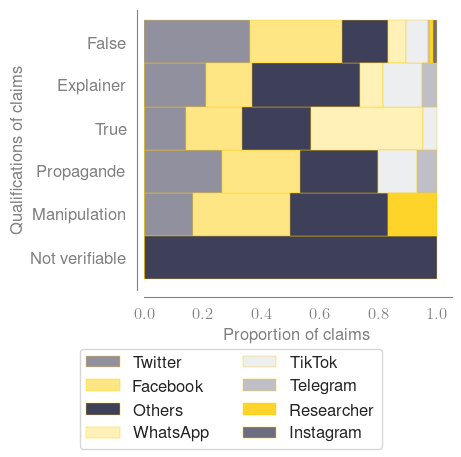

In [30]:
# Setting up the variables for the plot
field1 = 'qualification'

field2 = 'sources'
color_palette = colours_source_claims
df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

# Generating the plot
fig, ax = plt.subplots(layout='constrained')

filename, ax = plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, norm=False,  ax=ax)
ax.set_ylabel('Qualifications of claims')
ax.set_xlabel('Proportion of claims')

save_plot(fig, ax, filename, 'all')


plt.show()

## Source and Category of claims

In [31]:
field1 = 'sources'

field2 = 'categories'

color_palette = colours_cat_claims


df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

In [32]:
df_to_plot_norm

categories,Politics,Social,Personalities,Others,Fraud,Science,Gender,Migration/Racism,Security,Religion,Health,Enviromental disasters,Consume,Sexuality,Terrorism,Food,Alerts,Trabajo / Trabalho
sources,,,,,,,,,,,,,,,,,,
Instagram,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Researcher,0.166667,0.166667,0.000000,0.166667,0.000000,0.000000,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Telegram,0.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.142857,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000
WhatsApp,0.096774,0.258065,0.032258,0.064516,0.225806,0.032258,0.064516,0.096774,0.000000,0.064516,0.000000,0.032258,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000
TikTok,0.200000,0.257143,0.085714,0.057143,0.028571,0.057143,0.085714,0.000000,0.057143,0.057143,0.028571,0.028571,0.057143,0.000000,0.000000,0.000000,0.000000,0.000000
Others,0.238095,0.095238,0.142857,0.035714,0.095238,0.142857,0.047619,0.023810,0.023810,0.023810,0.059524,0.000000,0.011905,0.047619,0.000000,0.000000,0.000000,0.011905
Facebook,0.267241,0.189655,0.086207,0.086207,0.060345,0.034483,0.043103,0.043103,0.043103,0.025862,0.008621,0.025862,0.043103,0.008621,0.008621,0.017241,0.008621,0.000000
Twitter,0.307087,0.228346,0.110236,0.062992,0.000000,0.031496,0.055118,0.047244,0.031496,0.023622,0.031496,0.031496,0.007874,0.023622,0.007874,0.000000,0.000000,0.000000


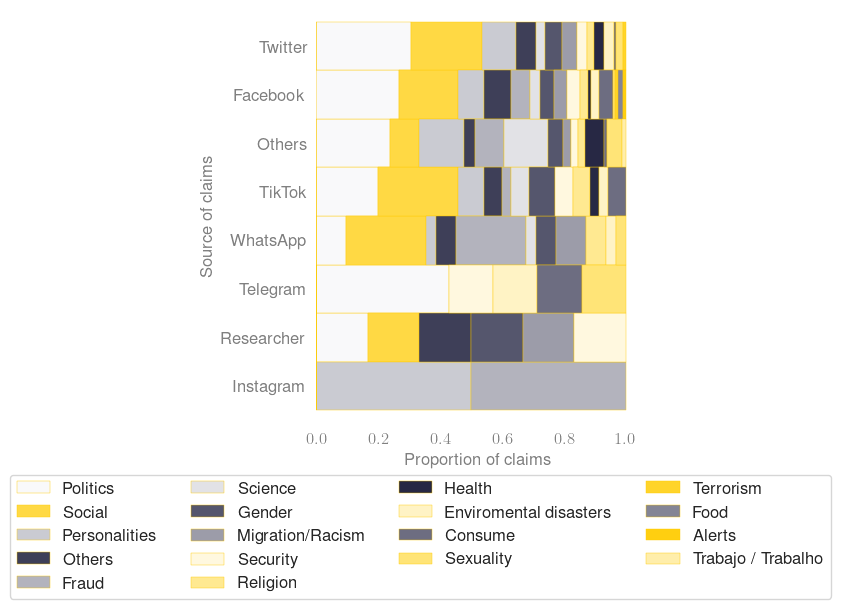

In [33]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, norm=True,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Source of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'all', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

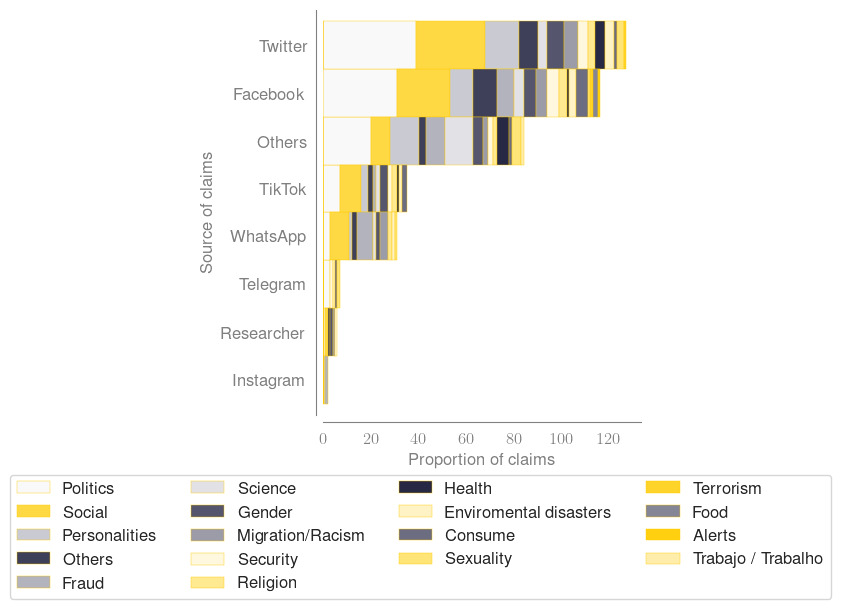

In [34]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot, field1, field2, colours=color_palette, norm=False,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Source of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'all', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

## Category and qualification

In [35]:

field1 = 'categories'
field2 = 'qualification'

color_palette = colours_qualification_claims


df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

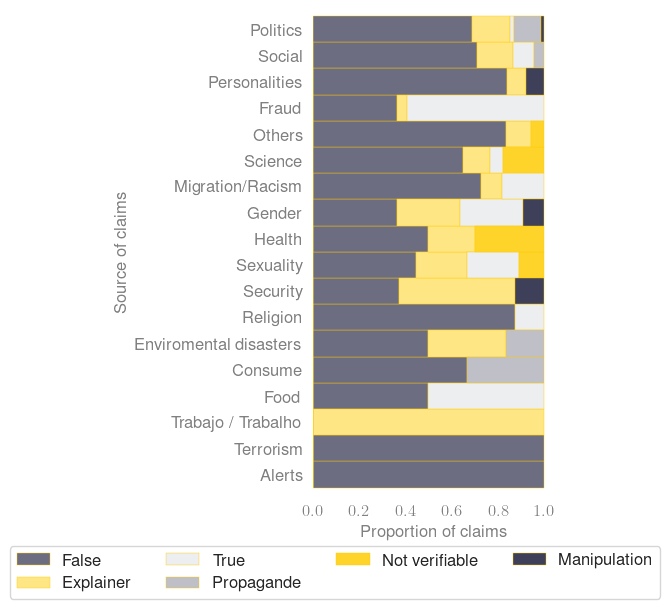

In [36]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, norm=True,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Source of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'all', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

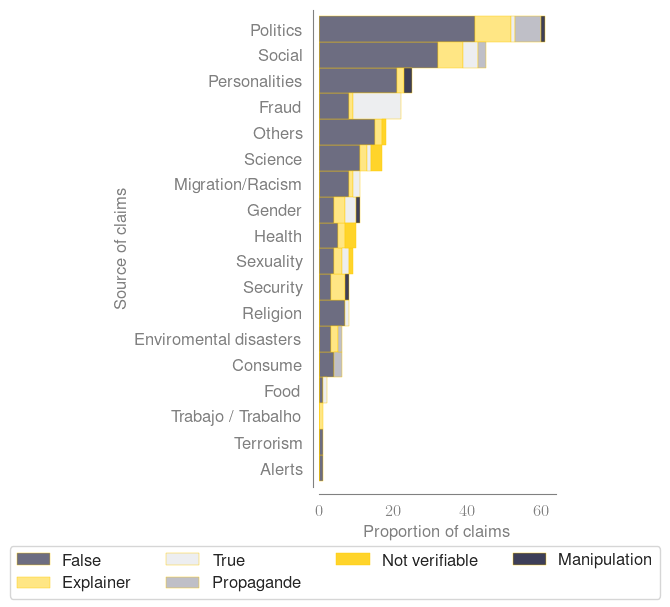

In [37]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot, field1, field2, colours=color_palette, norm=False,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Source of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'all', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

In [38]:
df_to_plot_norm

qualification,False,Explainer,True,Propagande,Not verifiable,Manipulation
categories,,,,,,
Alerts,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Terrorism,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Trabajo / Trabalho,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Food,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000
Consume,0.666667,0.000000,0.000000,0.333333,0.000000,0.000000
Enviromental disasters,0.500000,0.333333,0.000000,0.166667,0.000000,0.000000
Religion,0.875000,0.000000,0.125000,0.000000,0.000000,0.000000
Security,0.375000,0.500000,0.000000,0.000000,0.000000,0.125000
Sexuality,0.444444,0.222222,0.222222,0.000000,0.111111,0.000000


## Category and qualification

In [39]:
field1 = 'categories'

field2 = 'type'

color_palette = colours_type_claims


df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier, field1, field2)

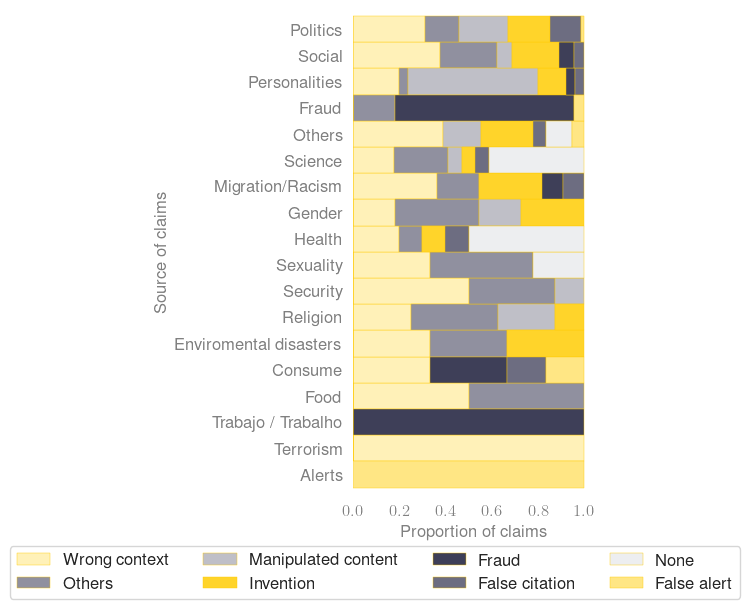

In [40]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot_norm, field1, field2, colours=color_palette, norm=True,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Source of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'all', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

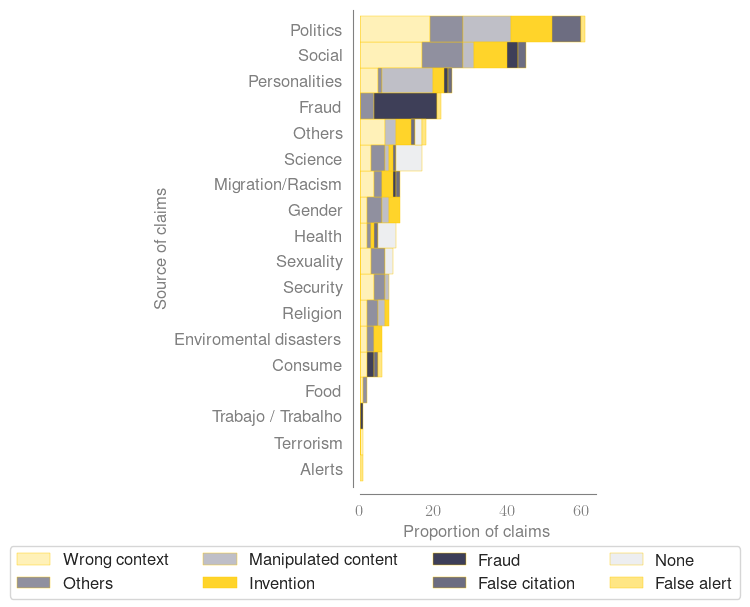

In [41]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot, field1, field2, colours=color_palette, norm=False,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Source of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'all', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

# Experiment subset

## Overview

In [42]:
datasources = ['Claims','News',  'Tweets' ]
df_overview = pd.DataFrame({'Data source': datasources, 'Dataset': ['All']*3, 'Counts': eval_count})
df_overview#.plot(kind='bar')

,Data source,Dataset,Counts
0,Claims,All,82
1,News,All,1133
2,Tweets,All,96380


In [43]:
datasources = ['Claims','News',  'Tweets', ]
df_overview = pd.DataFrame({'Data source': datasources*2, 'Dataset': ['All']*3 +['Experiment subset']*3, 'Counts': all_count+eval_count})
table = df_overview.pivot(index='Data source', columns='Dataset', values='Counts')
table['Difference'] = table['All'] - table['Experiment subset']
table

Dataset,All,Experiment subset,Difference
Data source,,,
Claims,167,82,85
News,1391,1133,258
Tweets,143327,96380,46947


In [44]:
# # define the subplots
# fig, ax = plt.subplots(3, layout='constrained')

# sns.despine(offset=5, trim=False)

# # plot each line in a separate subplot
# sns.barplot(data=df_overview[df_overview['Data source'] == 'Claims'], x='Data source', y='Counts', hue='Dataset',  ax=ax[0], palette=[main_color, second_color])
# sns.barplot(data=df_overview[df_overview['Data source'] == 'Tweets'], x='Data source', y='Counts', hue='Dataset',  ax=ax[1], palette=[main_color, second_color], legend=None)
# sns.barplot(data=df_overview[df_overview['Data source'] == 'News'], x='Data source', y='Counts', hue='Dataset',  ax=ax[2], palette=[main_color, second_color], legend=None)
# # add titles and axis labels
# ax[0].set_xlabel('')
# ax[1].set_xlabel('')
# ax[2].set_xlabel('')


# # Removing y-axis labels
# ax[0].set_ylabel('')
# #ax[1].set_ylabel('')
# ax[2].set_ylabel('')

# #fig.legend(loc='outside lower center', ncol=2)
# ax[0].legend().remove()
# ax[1].legend().remove()
# ax[2].legend().remove()

# filename = f'overview_subsets'
# save_plot(fig, ax, filename, 'exp', legend=True)
# plt.show()

### Category


,categories,Counts,Percentages
0,Politics,40,29.2
1,Social,31,22.6
2,Personalities,20,14.6
3,Science,7,5.1
4,Religion,7,5.1
5,Migration/Racism,6,4.4
6,Fraud,5,3.6
7,Health,4,2.9
8,Gender,4,2.9
9,Sexuality,4,2.9


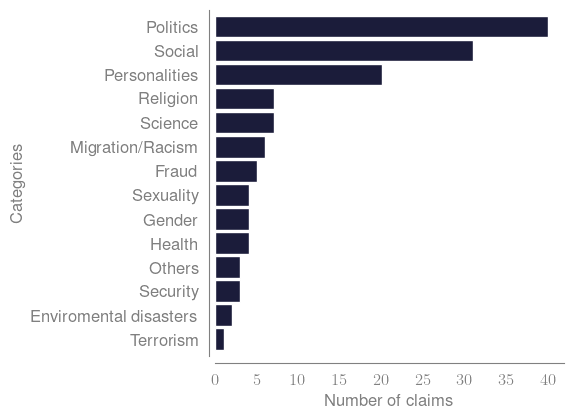

In [45]:
field = 'categories'

# Get the counts
field_counts = get_values_count(df_iberifier[df_iberifier['experience_subset'] == True], field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier[df_iberifier['experience_subset'] == True], 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Categories')
ax.set_xlabel('Number of claims')

## Save the plot
save_plot(fig, ax, filename, 'exp', legend=False)

# Output the table
field_counts

### Type

,type,Counts,Percentages
0,Wrong context,24,29.3
1,Others,18,22.0
2,Manipulated content,17,20.7
3,Invention,16,19.5
4,False citation,4,4.9
5,Fraud,3,3.7


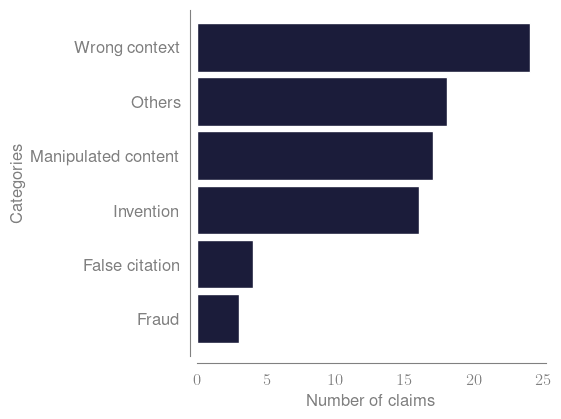

In [46]:
field = 'type'

# Get the counts
field_counts = get_values_count(df_iberifier[df_iberifier['experience_subset'] == True], field)

# Get per days
field_dates, field_dates_norm = output_df_for_cross(df_iberifier[df_iberifier['experience_subset'] == True], 'date', field, reorder_first=False, reorder_second=True)

# Get the table
## Save the table
#field_counts.to_csv(f"./tables/{sample}_proportion_{field}.csv")

# Get the plot
filename, fig, ax = plot_counts(field_counts, field, kind_bar='barh')
ax.set_ylabel('Categories')
ax.set_xlabel('Number of claims')

## Save the plot
save_plot(fig, ax, filename, 'exp', legend=False)

# Output the table
field_counts

### Category vs type

In [47]:
field1 = 'categories'

field2 = 'type'

color_palette = colours_type_claims
#color_palette = colours_cat_claims


df_to_plot, df_to_plot_norm = output_df_for_cross(df_iberifier[df_iberifier['experience_subset'] == True], field1, field2)

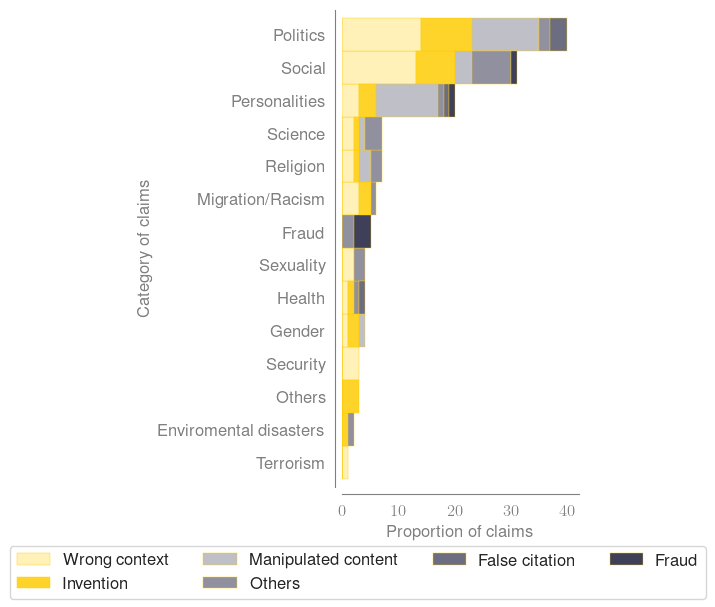

In [48]:
# Generating the plot
fig, ax = plt.subplots(layout='constrained', figsize=(5, 7))

filename, ax = plot_cross(df_to_plot, field1, field2, colours=color_palette, norm=False,  ax=ax)
fig.legend(loc='outside lower center', ncol=3)
ax.legend().remove()
ax.set_ylabel('Category of claims')
ax.set_xlabel('Proportion of claims')


save_plot(fig, ax, filename, 'exp', legend=True, eps_size=(4.5, 6), png_size=(7, 10), ncol_legend=4)

plt.show()

In [49]:
df_to_plot

type,Wrong context,Invention,Manipulated content,Others,False citation,Fraud
categories,,,,,,
Terrorism,1,0,0,0,0,0
Enviromental disasters,0,1,0,1,0,0
Others,0,3,0,0,0,0
Security,3,0,0,0,0,0
Gender,1,2,1,0,0,0
Health,1,1,0,1,1,0
Sexuality,2,0,0,2,0,0
Fraud,0,0,0,2,0,3
Migration/Racism,3,2,0,1,0,0


# Topic relation

In [50]:
tweets_topic_count  = df_tweets[df_tweets['topic_relation_subset'] == True]['topic_relation'].value_counts().to_frame().reset_index()
tweets_topic_count.columns = ['Topic relation', 'Tweets'] 
tweets_topic_count

,Topic relation,Tweets
0,off-topic,81528
1,on-topic,14852


In [51]:
news_topic_count  = df_mynews[df_mynews['topic_relation_subset'] == True]['topic_relation'].value_counts().to_frame().reset_index()
news_topic_count.columns = ['Topic relation', 'News articles']
news_topic_count

,Topic relation,News articles
0,on-topic,637
1,off-topic,496


In [52]:
tweets_topic_count

,Topic relation,Tweets
0,off-topic,81528
1,on-topic,14852


In [53]:
merged_df = pd.merge(tweets_topic_count, news_topic_count, on='Topic relation')
merged_df

,Topic relation,Tweets,News articles
0,off-topic,81528,496
1,on-topic,14852,637


In [54]:
# create the percentage columns
total_tweets = sum(merged_df['Tweets'])
total_news_articles = sum(merged_df['News articles'])

merged_df['% Tweets'] = merged_df['Tweets'].apply(lambda x: '{:.2f}%'.format((x/total_tweets)*100))
merged_df['% News articles'] = merged_df['News articles'].apply(lambda x: '{:.2f}%'.format((x/total_news_articles)*100))

# create the total percentage row
total_row = pd.DataFrame({
    'Topic relation': 'Total',
    'Tweets': sum(merged_df['Tweets']),
    'News articles': sum(merged_df['News articles']),
    '% Tweets': '{:.2f}%'.format((sum(merged_df['Tweets'])/total_tweets)*100),
    '% News articles': '{:.2f}%'.format((sum(merged_df['News articles'])/total_news_articles)*100)
}, index=[len(merged_df)])

# append the total row to the dataframe
merged_df_perc = pd.concat([merged_df, total_row])

# display the dataframe
print(merged_df_perc)

  Topic relation  Tweets  News articles % Tweets % News articles
0      off-topic   81528            496   84.59%          43.78%
1       on-topic   14852            637   15.41%          56.22%
2          Total   96380           1133  100.00%         100.00%


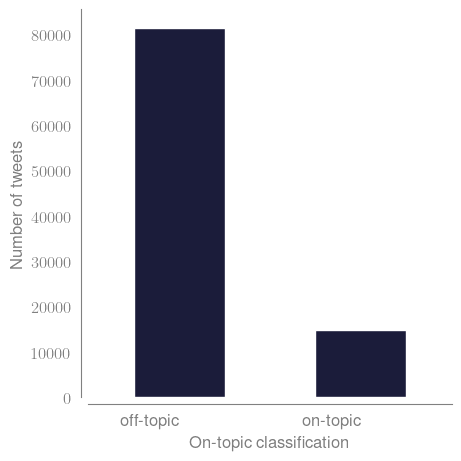

In [55]:
fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False);
#tweets_topic_count['count']
tweets_topic_count.plot(kind='bar', y='Tweets', ax=ax, color=main_color)
ax.legend().remove()
ax.set_ylabel('Number of tweets')
ax.set_xticks([0,1],['off-topic', 'on-topic'])
#ax[1].set_ylabel('')
ax.set_xlabel('On-topic classification')
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
filename = 'tweets_counts'
save_plot(fig, ax, filename, 'ontopic', legend=False)

plt.show()

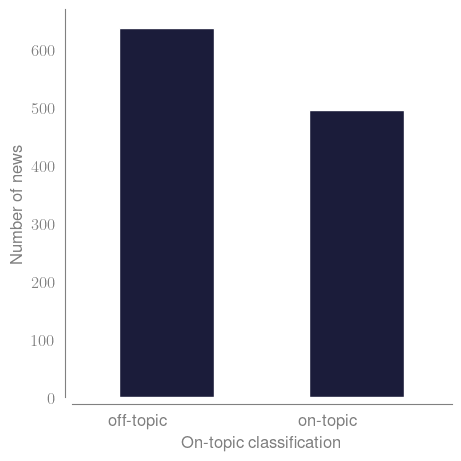

In [56]:
fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False);
#tweets_topic_count['count']
news_topic_count.plot(kind='bar', y='News articles', ax=ax, color=main_color)
ax.legend().remove()
ax.set_ylabel('Number of news')
ax.set_xticks([0,1],['off-topic', 'on-topic'])
#ax[1].set_ylabel('')
ax.set_xlabel('On-topic classification')
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
filename = 'mynews_counts'
save_plot(fig, ax, filename, 'ontopic', legend=False)

plt.show()

# On topic

In [57]:
def plot_box_ontopic(df, field, source, color, legend_position=None, ax=None):
    fig = None
    if ax is None:
        fig, ax = plt.subplots(layout='constrained')
    sns.despine(offset=5, trim=False);
    order = df.groupby(field).median().sort_values(by=0, ascending=False).index

    #fig.suptitle(f"{field1} and {field2} of claims [{min(df_iberifier['date'])} - {max(df_iberifier['date'])}]")
    plot = sns.boxplot(df, x=field, color= color, y=0, showfliers = False, order=order, ax=ax, medianprops=dict(color='white'))
    ax.set(xlabel=f'')
    ax.set(ylabel=f'')
    filename = f'{source}_{field}'
    return filename, fig, ax

## Mynews on topic

In [58]:
mynews_on_topic = df_mynews[(df_mynews['topic_relation'] == 'on-topic') & (df_mynews['topic_relation_subset'] == True)]

iberifier_columns = ['date', 'time', 'sources', 'fact_id', 'categories', 'type', 'fact_checker', 'qualification']
# Merge the iberifier onto the tweets based on the fact_id
mynews_iberifier = pd.merge(mynews_on_topic, df_iberifier[iberifier_columns], on='fact_id', how='left')

# Rename the date to avoid confusion
mynews_iberifier = mynews_iberifier.rename(columns={'date_x': 'date_news', 'date_y': 'date_fact_check', 'time_x': 'time_news', 'time_y': 'time_fact_check'})
mynews_to_plot_counts = mynews_iberifier.groupby([mynews_iberifier['date_news'], mynews_iberifier['Newspaper']]).size().unstack()


mynews_line = mynews_iberifier.groupby(mynews_iberifier['date_news']).size()

mynews_all_bar = mynews_iberifier[['date_news', 'Newspaper']].groupby([mynews_iberifier['date_news'], mynews_iberifier['Newspaper']]).size().unstack().fillna(0)

In [59]:
mynews_on_topic.groupby('fact_id').size().describe()

count    61.000000
mean     10.442623
std      15.033878
min       1.000000
25%       2.000000
50%       4.000000
75%      11.000000
max      67.000000
dtype: float64

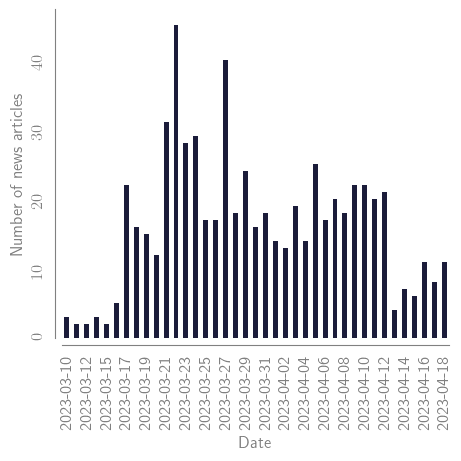

In [60]:
sns.set_style("white")
fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False);


#ax.plot(data=mynews_iberifier, kind='bar', stacked=True, ax=ax, linewidth=0,legend=False, alpha=0.2)
#ax.plot_date(mynews_to_plot_counts.index, mynews_to_plot_counts.values, '--', label='News articles', color=main_color)

#ax.plot_date(mynews_line.index, mynews_line.values, '--', label='News articles', color=main_color)

ax.plot_date(mynews_line.index, mynews_line.values, '--', label='News articles', color=main_color)
ax.fill_between(mynews_line.index, mynews_line.values, alpha=0.3, color=main_color)
mynews_all_bar.plot(kind='bar', stacked=True,linewidth=0,legend=False, ax=ax, color=main_color)

#ax.plot_date(mynews_line.index, mynews_line.values, linewidth=10)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
#plt.tight_layout()
ax.set_xlabel('Date')
ax.set_ylabel('Number of news articles')

filename = f'mynews_overtime'
#save_plot(fig, ax, filename, sample)
save_plot(fig, ax, filename, 'ontopic', legend=False)

plt.show()

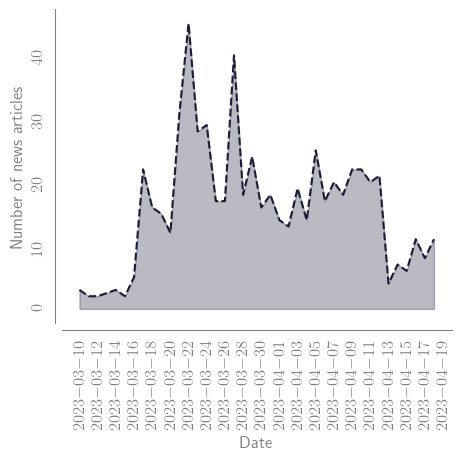

In [61]:
sns.set_style("white")
fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False);

ax.plot_date(mynews_line.index, mynews_line.values, '--', label='News articles', color=main_color)
ax.fill_between(mynews_line.index, mynews_line.values, alpha=0.3, color=main_color)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Number of news articles')

filename = f'mynes_overtime_cat'
#save_plot(fig, ax, filename, sample)

#plt.savefig('./plots/newspaper_overtime.png', bbox_inches='tight')
save_plot(fig, ax, filename, 'ontopic', legend=False)

plt.show()

### Categories

In [62]:
def match_mynews_factcheck_feature(df, feature_columns):
    try:
        group_feature = df.groupby(['fact_id', feature_columns]).size()

    except TypeError: # In case it is a list
        group_feature = df.explode(feature_columns).groupby(['fact_id', feature_columns]).size()
    group_feature = group_feature.reset_index(level='fact_id', drop=True).reset_index()#.sort_values(by=0, ascending=False)
    #group_feature = group_feature.assign(tmp=group_feature.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)

    return group_feature

In [63]:
field_cat = 'categories'

# Define the colour for the fact-checker to be coherent
grouped_data_cat = match_mynews_factcheck_feature(mynews_iberifier, field_cat)
stats_per_features_cat = grouped_data_cat.groupby(field_cat).describe()
#stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{field}.csv")
stats_per_features_cat

0                                                    
                 count       mean        std  min   25%   50%    75%   max
categories                                                                
Fraud              2.0   4.000000   4.242641  1.0  2.50   4.0   5.50   7.0
Gender             2.0   3.000000   2.828427  1.0  2.00   3.0   4.00   5.0
Health             4.0   2.250000   0.957427  1.0  1.75   2.5   3.00   3.0
Migration/Racism   5.0  11.600000  19.295077  1.0  2.00   4.0   5.00  46.0
Others             1.0   5.000000        NaN  5.0  5.00   5.0   5.00   5.0
Personalities     15.0   6.400000   6.423172  1.0  2.50   4.0   6.50  24.0
Politics          31.0  10.000000  14.075984  1.0  2.00   4.0  11.00  65.0
Religion           4.0  12.500000  10.661457  1.0  4.75  13.0  20.75  23.0
Science            7.0  16.142857  25.353689  1.0  2.00   3.0  19.00  67.0
Security           2.0   3.000000   2.828427  1.0  2.00   3.0   4.00   5.0
Sexuality          1.0   3.000000        NaN  3.0  3.00   3.0   3.00   3.0
Social            26.0  14.576923  17.700109  1.0  2.25   5.0  19.50  65.0
Terrorism          1.0   3.000000        NaN  3.0  3.00   3.0   3.00   3.0

In [64]:
## Grouping the data with <= 1 fact_ids to others
under_threshold_categories = stats_per_features_cat[stats_per_features_cat[0]['count'] <= 1].index.values
replacing_dict = {k: 'Others' for k in under_threshold_categories}
grouped_data_cat_plot = grouped_data_cat
grouped_data_cat_plot[field_cat] = grouped_data_cat_plot[field_cat].replace(replacing_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


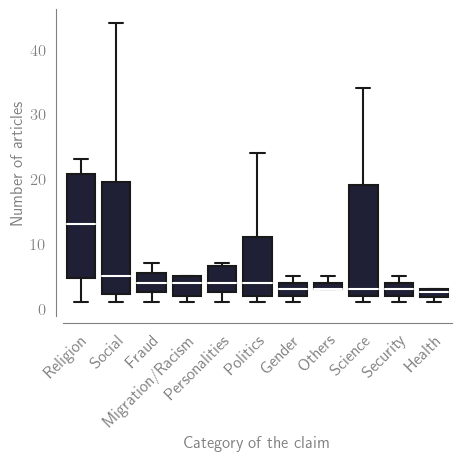

In [65]:

filename_cat, fig_cat, ax_cat = plot_box_ontopic(grouped_data_cat_plot, field_cat, 'mynews', main_color)
plt.setp(ax_cat.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_cat.set_ylabel('Number of articles')
ax_cat.set_xlabel('Category of the claim')
save_plot(fig_cat, ax_cat, filename_cat, 'ontopic', legend=False)


plt.show()

### Type

In [66]:
field_cat = 'type'

# Define the colour for the fact-checker to be coherent
grouped_data_cat = match_mynews_factcheck_feature(mynews_iberifier, field_cat)
stats_per_features_cat = grouped_data_cat.groupby(field_cat).describe()
#stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{field}.csv")
stats_per_features_cat

0                                                   
                    count       mean        std  min   25%  50%    75%   max
type                                                                        
False citation        2.0   2.500000   0.707107  2.0  2.25  2.5   2.75   3.0
Fraud                 1.0   7.000000        NaN  7.0  7.00  7.0   7.00   7.0
Invention            11.0   5.272727   4.692354  1.0  3.00  5.0   5.00  18.0
Manipulated content  15.0   9.133333   8.634372  1.0  2.00  6.0  14.50  27.0
Others               13.0  12.923077  20.163753  1.0  2.00  3.0  12.00  67.0
Wrong context        19.0  13.789474  19.245718  1.0  1.00  4.0  17.00  65.0

In [67]:
## Grouping the data with <= 1 fact_ids to others
under_threshold_categories = stats_per_features_cat[stats_per_features_cat[0]['count'] <= 1].index.values
replacing_dict = {k: 'Others' for k in under_threshold_categories}
grouped_data_cat_plot = grouped_data_cat
grouped_data_cat_plot[field_cat] = grouped_data_cat_plot[field_cat].replace(replacing_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


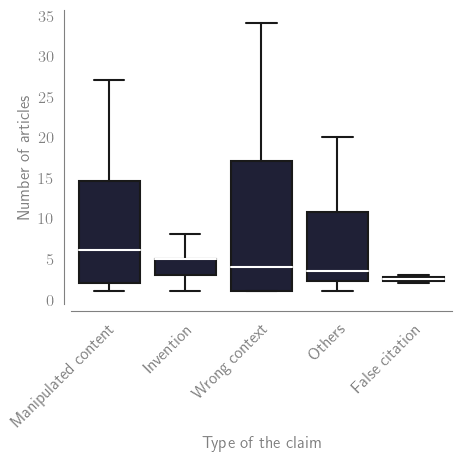

In [68]:

filename_cat, fig_cat, ax_cat = plot_box_ontopic(grouped_data_cat_plot, field_cat, 'mynews', main_color)
plt.setp(ax_cat.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_cat.set_ylabel('Number of articles')
ax_cat.set_xlabel('Type of the claim')
save_plot(fig_cat, ax_cat, filename_cat, 'ontopic', legend=False)


plt.show()

## Tweets on topic

In [69]:
# Get the number of fact_id per tweets
# Explode tweets on fact_id list
# Only using on-topic withing the topic_relation_subset is True
tweets_exploded = df_tweets.explode('fact_id')

iberifier_columns = ['date', 'time', 'sources', 'fact_id', 'categories', 'type', 'fact_checker', 'qualification']
# Merge the iberifier onto the tweets based on the fact_id
tweets_iberifier = pd.merge(tweets_exploded, df_iberifier[iberifier_columns], on='fact_id', how='left')

# Rename the date to avoid confusion
tweets_iberifier = tweets_iberifier.rename(columns={'date_x': 'date_tweet', 'date_y': 'date_fact_check', 'time_x': 'time_tweet', 'time_y': 'time_fact_check'})

# Replace nan values in the categories with string None  
# FIXME Should be removed as soon as run on the new dataset as it is probably a bug from earlier in pipeline
#tweets_iberifier = tweets_iberifier[['categories', 'type', 'qualification']].fillna('None')

In [70]:
tweets_ontopic = tweets_iberifier[(tweets_iberifier['topic_relation'] == 'on-topic') & (tweets_iberifier['topic_relation_subset'] == True)]

In [71]:
tweets_ontopic.groupby('fact_id').size().describe()

count      82.000000
mean      186.109756
std       423.273983
min         1.000000
25%         7.250000
50%        26.500000
75%       105.250000
max      2108.000000
dtype: float64

In [72]:
def match_tweet_factcheck_feature(df, feature_columns):
    try:
        group_feature = df.groupby(['fact_id', feature_columns]).size()

    except TypeError: # In case it is a list
        group_feature = df.explode(feature_columns).groupby(['fact_id', feature_columns]).size()
    group_feature = group_feature.reset_index(level='fact_id', drop=True).reset_index()#.sort_values(by=0, ascending=False)
    #group_feature = group_feature.assign(tmp=group_feature.sum(axis=1)).sort_values('tmp', ascending=True).drop(labels='tmp', axis=1)

    return group_feature

### Categories

In [73]:
field_cat = 'categories'

# Define the colour for the fact-checker to be coherent
grouped_data_cat = match_tweet_factcheck_feature(tweets_ontopic, field_cat)
stats_per_features_cat = grouped_data_cat.groupby(field_cat).describe()
#stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{field}.csv")
stats_per_features_cat

0                                             \
                       count        mean         std   min    25%   50%   
categories                                                                
Enviromental disasters   2.0    8.000000    5.656854   4.0   6.00   8.0   
Fraud                    4.0   14.000000    9.899495   3.0   9.75  13.0   
Gender                   4.0   13.750000   16.028620   1.0   4.75   8.5   
Health                   4.0  200.000000  321.304632   8.0   8.75  57.5   
Migration/Racism         6.0   75.833333   77.352225   8.0  28.00  55.0   
Others                   5.0   79.400000  151.424238   1.0   2.00   8.0   
Personalities           21.0  274.238095  593.340535   2.0   6.00  23.0   
Politics                38.0  216.105263  418.547927   1.0   8.25  28.0   
Religion                 7.0  211.000000  256.114558   5.0  32.00  99.0   
Science                  7.0   76.142857   91.123412   5.0  16.00  38.0   
Security                 2.0   16.500000   16.263456   5.0  10.75  16.5   
Sexuality                3.0    3.333333    2.081666   1.0   2.50   4.0   
Social                  31.0  219.838710  509.401943   1.0   9.50  37.0   
Terrorism                1.0   38.000000         NaN  38.0  38.00  38.0   

                                        
                           75%     max  
categories                              
Enviromental disasters   10.00    12.0  
Fraud                    17.25    27.0  
Gender                   17.50    37.0  
Health                  248.75   677.0  
Migration/Racism         86.50   221.0  
Others                   37.00   349.0  
Personalities            99.00  2108.0  
Politics                193.75  1713.0  
Religion                355.00   599.0  
Science                  97.50   263.0  
Security                 22.25    28.0  
Sexuality                 4.50     5.0  
Social                   94.00  2108.0  
Terrorism                38.00    38.0

In [74]:
## Grouping the data with <= 1 fact_ids to others
under_threshold_categories = stats_per_features_cat[stats_per_features_cat[0]['count'] <= 1].index.values
replacing_dict = {k: 'Others' for k in under_threshold_categories}
grouped_data_cat_plot = grouped_data_cat
grouped_data_cat_plot['categories'] = grouped_data_cat_plot['categories'].replace(replacing_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


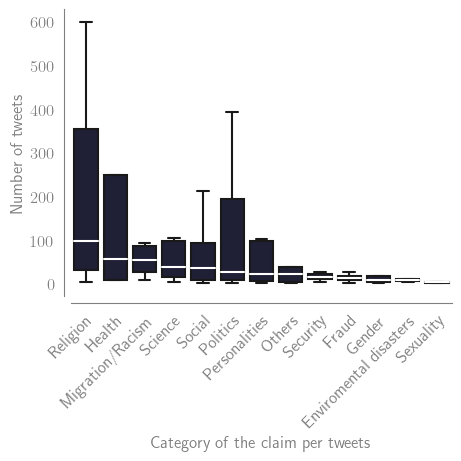

In [75]:

filename_cat, fig_cat, ax_cat = plot_box_ontopic(grouped_data_cat_plot, field_cat, 'tweets', main_color)
plt.setp(ax_cat.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_cat.set_ylabel('Number of tweets')
ax_cat.set_xlabel('Category of the claim per tweets')
save_plot(fig_cat, ax_cat, filename_cat, 'ontopic', legend=False)


plt.show()

#### Type of disinformation

In [77]:
field_type = 'type'
# Define the colour for the fact-checker to be coherent
#colours_type_claims = define_colours(tweets_ontopic, field_type)
grouped_data_type = match_tweet_factcheck_feature(tweets_ontopic, field_type)
stats_per_features_type = grouped_data_type.groupby(field_type).describe()
#stats_per_features.to_csv(f"./tables/{sample}_tweets_per_{field}.csv")
stats_per_features_type

0                                                     \
                    count        mean         std  min    25%    50%     75%   
type                                                                           
False citation        3.0   14.000000   14.000000  4.0   6.00    8.0   19.00   
Fraud                 3.0   14.666667   12.013881  3.0   8.50   14.0   20.50   
Invention            16.0  125.562500  217.465390  5.0   8.75   24.5   82.25   
Manipulated content  17.0  215.941176  450.678027  1.0   6.00   23.0  103.00   
Others               16.0  360.000000  664.932478  4.0  11.25  109.0  231.50   
Wrong context        25.0  148.840000  358.620816  1.0   5.00   38.0   93.00   

                             
                        max  
type                         
False citation         30.0  
Fraud                  27.0  
Invention             677.0  
Manipulated content  1713.0  
Others               2108.0  
Wrong context        1693.0

In [78]:
## Grouping the data with <= 1 fact_ids to others
under_threshold_type = stats_per_features_type[stats_per_features_type[0]['count'] <= 1].index.values
replacing_dict = {k: 'Others' for k in under_threshold_type}
grouped_data_type_plot = grouped_data_type
grouped_data_type_plot['type'] = grouped_data_type_plot['type'].replace(replacing_dict)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


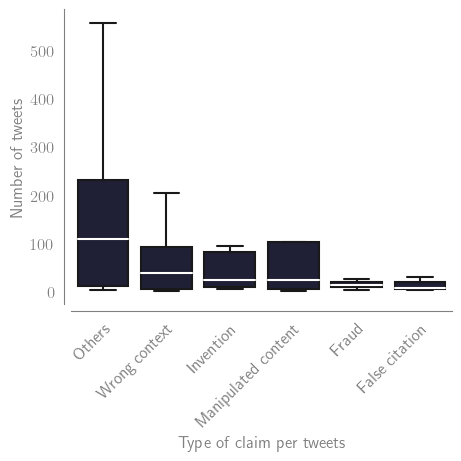

In [79]:
filename_type, fig_type, ax_type = plot_box_ontopic(grouped_data_type_plot, field_type, 'tweets', main_color 
)
plt.setp(ax_type.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax_type.set_ylabel('Number of tweets')
ax_type.set_xlabel('Type of claim per tweets')

save_plot(fig_type, ax_type, filename_type, 'ontopic', legend=False)


plt.show()

# On Claims 

In [80]:
tweets_claims = tweets_iberifier[(tweets_iberifier['experience_subset'] == True)].explode('fact_id')

In [81]:
len(tweets_iberifier['fact_id'].unique())

110

In [82]:
# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_claims['diff_date'] = (pd.to_datetime(tweets_claims['date_tweet']) - pd.to_datetime(tweets_claims['date_fact_check'])).dt.days
tweets_claims['diff_date'] = tweets_claims['diff_date'].fillna(0)
tweets_claims['diff_date'] = tweets_claims['diff_date'].astype('int') 

# Groupby and get the impact size for each of fact_id - Fill nan with 0 as it means nothing was collected before

                                                                                                  
             
# Create the diff date for the plot
diff_date = tweets_claims.groupby(['fact_id', 'diff_date']).size().reset_index()
diff_date_per_factchecker = tweets_claims.groupby(['fact_id', 'diff_date', 'fact_checker']).size().reset_index()[['diff_date', 'fact_checker', 0]]
diff_date_per_support_claim = tweets_claims.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).size().reset_index()[['diff_date', 'claim_finer_relation', 0]]

## Grouping by tweets metrics
diff_date_metrics = tweets_claims.groupby(['fact_id', 'diff_date']).agg({'retweet_count': 'sum', 
                                                              'reply_count': 'sum', 
                                                              'like_count': 'sum',
                                                              'quote_count': 'sum',
                                                              'impression_count': 'sum'})

diff_date_metrics_support_claim = tweets_claims.groupby(['fact_id', 'diff_date', 'claim_finer_relation']).agg({'retweet_count': 'sum', 
                                                              'reply_count': 'sum', 
                                                              'like_count': 'sum',
                                                              'quote_count': 'sum',
                                                              'impression_count': 'sum'}).reset_index()

In [83]:
tweets_claims.groupby('claim_finer_relation').size()

claim_finer_relation
disseminates        4291
not-disseminates    1739
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


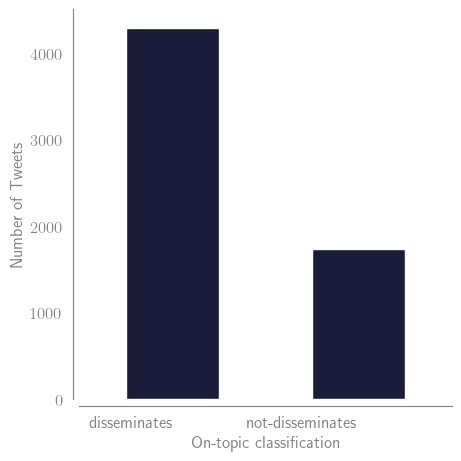

In [84]:
fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False);
#tweets_topic_count['count']
tweets_claims.groupby('claim_finer_relation').size().plot(kind='bar', ax=ax, color=main_color)
ax.legend().remove()
ax.set_ylabel('Number of Tweets')
ax.set_xticks([0,1],['disseminates', 'not-disseminates'])
#ax[1].set_ylabel('')
ax.set_xlabel('On-topic classification')
plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")
filename = 'disseminates_not_counts'
save_plot(fig, ax, filename, 'onclaim', legend=False)

plt.show()

## Using dates

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


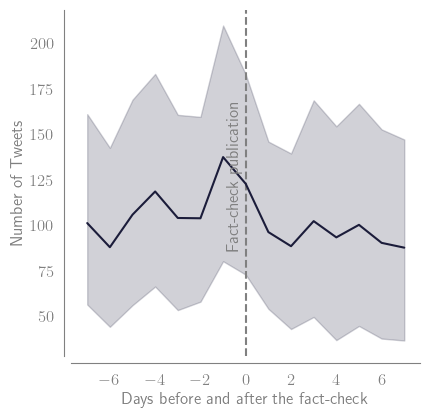

In [85]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')
ax = sns.lineplot(diff_date, x='diff_date', y=0, color=main_color)
ax.text(x=-0.5, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4+5, s='Fact-check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top', rotation='vertical' )
filename = 'impact_tweets_line_day'

ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Days before and after the fact-check')

save_plot(fig, ax, filename, 'onclaim', legend=False)

#save_plot(fig, ax, filename)

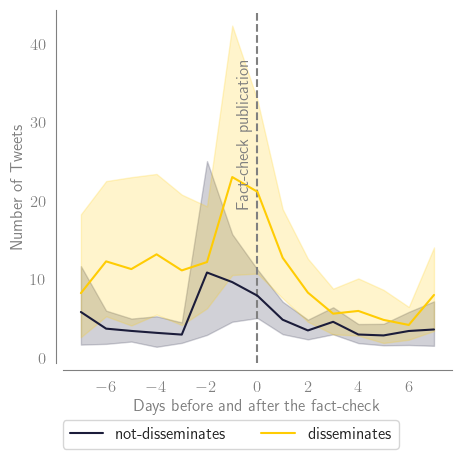

In [86]:
sns.set_style("white")

fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')

ax = sns.lineplot(diff_date_per_support_claim, x='diff_date', hue='claim_finer_relation', y=0, palette=[main_color, second_color])
ax.text(x=-0.5, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4+5, s='Fact-check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top', rotation='vertical' )
filename = 'impact_tweets_line_day_by_diss'
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Days before and after the fact-check')

save_plot(fig, ax, filename, 'onclaim', legend=True)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

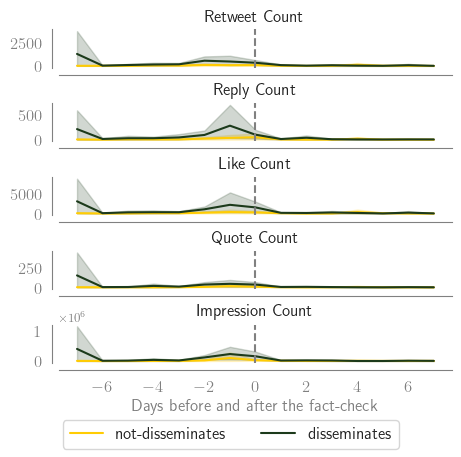

In [87]:
# define the subplots
fig, ax = plt.subplots(5,  sharex=True, layout='constrained')

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='retweet_count', hue='claim_finer_relation', palette=[second_color, third_color], ax=ax[0])
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='reply_count', hue='claim_finer_relation', palette=[second_color, third_color], ax=ax[1], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='like_count', hue='claim_finer_relation',palette=[second_color, third_color],  ax=ax[2], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='quote_count', hue='claim_finer_relation',palette=[second_color, third_color], ax=ax[3], legend=None)
sns.lineplot(data=diff_date_metrics_support_claim, x='diff_date', y='impression_count', hue='claim_finer_relation',palette=[second_color, third_color], ax=ax[4], legend=None)


# Draw line for the event
ax[0].axvline(x=0, ymax=ax[0].get_ylim()[1]/2, color='grey', linestyle='--')
ax[1].axvline(x=0, ymax=ax[1].get_ylim()[1]/2, color='grey', linestyle='--')
ax[2].axvline(x=0, ymax=ax[2].get_ylim()[1]/2, color='grey', linestyle='--')
ax[3].axvline(x=0, ymax=ax[3].get_ylim()[1]/2, color='grey', linestyle='--')
ax[4].axvline(x=0, ymax=ax[4].get_ylim()[1]/2, color='grey', linestyle='--')

# add titles and axis labels
ax[0].set_title('Retweet Count')
ax[1].set_title('Reply Count')
ax[2].set_title('Like Count')
ax[3].set_title('Quote Count')
ax[4].set_title('Impression Count')

# Removing y-axis labels
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
ax[4].set_ylabel('')

# Set the xlabel
ax[4].set_xlabel('Days before and after the fact-check')

filename = 'impact_tweets_metric_day_by_diss'
save_plot(fig, ax, filename, 'onclaim', legend=True)

plt.show()

### Using hours

In [88]:
# Calculate the difference in time between the time the tweet is published and the fact-check
tweets_claims['diff_time'] = (tweets_claims['time_tweet'] - tweets_claims['time_fact_check']).astype('timedelta64[h]')
# Fill the empty ones with 0 
tweets_claims['diff_time'] = tweets_claims['diff_time'].fillna(0)
#tweets_iberifier['diff_time'] = pd.to_timedelta(tweets_iberifier['diff_time']) /pd.Timedelta(hours=1)
# Create the diff date for the plot
diff_time = tweets_claims.groupby(['fact_id', 'diff_time']).size().reset_index()
diff_time_per_factchecker = tweets_claims.groupby(['fact_id', 'diff_time', 'fact_checker']).size().reset_index()[['diff_time', 'fact_checker', 0]]
diff_time_per_support_claim = tweets_claims.groupby(['fact_id', 'diff_time', 'claim_finer_relation']).size().reset_index()[['diff_time', 'claim_finer_relation', 0]]

## Grouping by tweets metrics
diff_time_metrics = tweets_claims.groupby(['fact_id', 'diff_time']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'}).reset_index().dropna()

diff_time_metrics_support_claim = tweets_claims.groupby(['fact_id', 'diff_time', 'claim_finer_relation']).agg({'retweet_count': 'mean', 
                                                              'reply_count': 'mean', 
                                                              'like_count': 'mean',
                                                              'quote_count': 'mean',
                                                              'impression_count': 'mean'}).reset_index().dropna()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


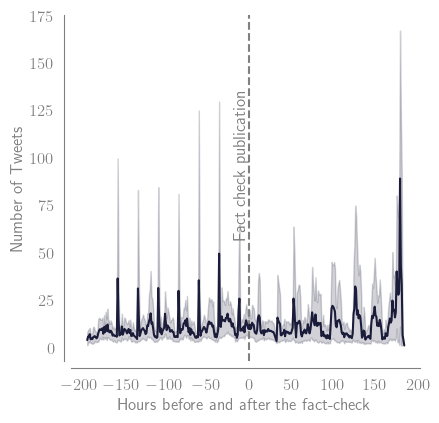

In [89]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6, 5))

sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')
ax = sns.lineplot(diff_time, x='diff_time', y=0, color=main_color)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Hours before and after the fact-check')
ax.text(x=-8, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4+5, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top', rotation='vertical' )
filename = 'impact_tweets_line_hours'

save_plot(fig, ax, filename, 'onclaim', legend=False)


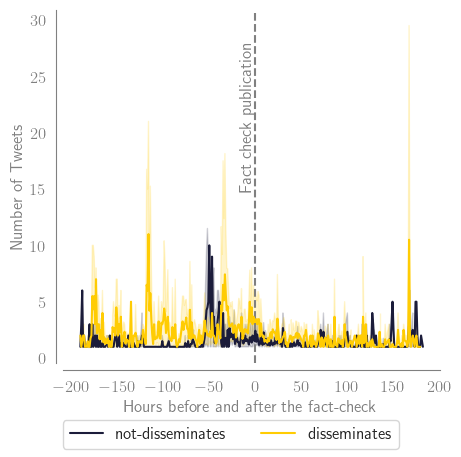

In [90]:


sns.set_style("white")

fig, ax = plt.subplots(layout='constrained')
sns.despine(offset=5, trim=False)
ax.axvline(x=0, color='grey', linestyle='--')

ax = sns.lineplot(diff_time_per_support_claim, x='diff_time', hue='claim_finer_relation', y=0, palette=[main_color, second_color])
ax.text(x=-8, y=ax.get_ylim()[1]-ax.get_ylim()[1]/4+5, s='Fact check publication', fontsize=12, color='grey', bbox={'boxstyle': 'round,pad=0.3', 'ec': 'none', 'fc': 'none'}, ha='center', va='top', rotation='vertical' )
# Set the xlabel
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Hours before and after the fact-check')
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

filename = 'impact_tweets_line_hours_by_diss'

save_plot(fig, ax,filename,  'onclaim')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

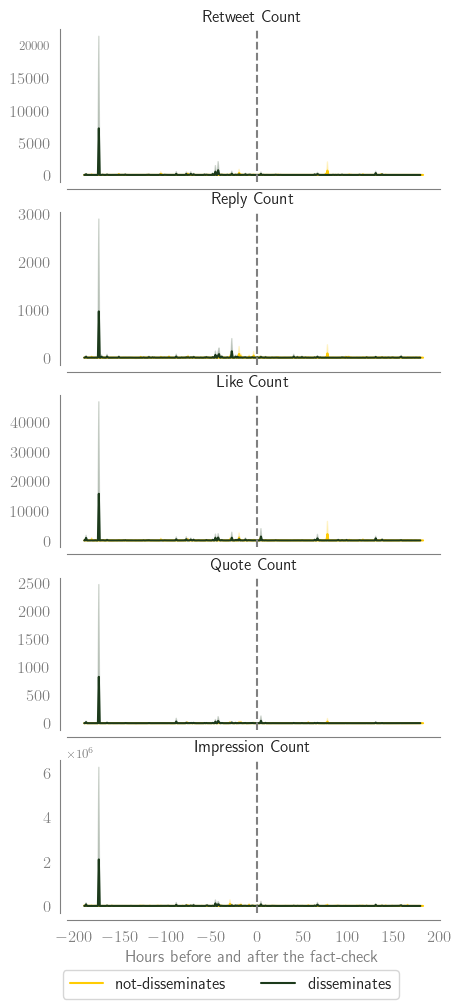

In [91]:
# define the subplots
fig, ax = plt.subplots(5,  sharex=True, layout='constrained', figsize=(4.5, 10))

sns.despine(offset=5, trim=False)

# plot each line in a separate subplot
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='retweet_count', hue='claim_finer_relation', palette=[second_color, third_color], ax=ax[0])
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='reply_count', hue='claim_finer_relation', palette=[second_color, third_color], ax=ax[1], legend=None)
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='like_count', hue='claim_finer_relation',palette=[second_color, third_color],  ax=ax[2], legend=None)
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='quote_count', hue='claim_finer_relation',palette=[second_color, third_color], ax=ax[3], legend=None)
sns.lineplot(data=diff_time_metrics_support_claim, x='diff_time', y='impression_count', hue='claim_finer_relation',palette=[second_color, third_color], ax=ax[4], legend=None)

ax[0].axvline(x=0, ymax=ax[0].get_ylim()[1]/2, color='grey', linestyle='--')
ax[1].axvline(x=0, ymax=ax[1].get_ylim()[1]/2, color='grey', linestyle='--')
ax[2].axvline(x=0, ymax=ax[2].get_ylim()[1]/2, color='grey', linestyle='--')
ax[3].axvline(x=0, ymax=ax[3].get_ylim()[1]/2, color='grey', linestyle='--')
ax[4].axvline(x=0, ymax=ax[4].get_ylim()[1]/2, color='grey', linestyle='--')

# add titles and axis labels
ax[0].set_title('Retweet Count')
ax[1].set_title('Reply Count')
ax[2].set_title('Like Count')
ax[3].set_title('Quote Count')
ax[4].set_title('Impression Count')

# Removing y-axis labels
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')
ax[4].set_ylabel('')

# Set the xlabel
ax[4].set_xlabel('Hours before and after the fact-check')
ax[4].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

filename = 'impact_tweets_metric_hours_by_diss'

save_plot(fig, ax,  filename, 'onclaim',eps_size=(4.5, 10))

plt.show()

## Test to see a difference before and after

### Overall test with all the on-topic claims

In [94]:
tweets_claims['impact'] = np.where(tweets_claims['diff_time'] < 0,  'Before/fact-check', np.where(tweets_claims['diff_time'] >= 0, 'After', 'ERROR'))

### Wilcoxon Signed Ranked test

In [95]:
impact = tweets_claims.groupby(['fact_id', 'impact']).size().reset_index().fillna(0)   
before = impact[impact['impact'] == 'Before/fact-check']
after = impact[impact['impact'] == 'After']
fact_both = list(set(before['fact_id']).intersection(after['fact_id']))
len(fact_both)

77

In [96]:
tweets_claims[tweets_claims['impact'] =='ERROR']

,tweet_id,fact_id,text,topic_relation,claim_relation,claim_finer_relation,db_id,date_tweet,tweet.text,tweet.created_at,...,date_fact_check,time_fact_check,sources,categories,type,fact_checker,qualification,diff_date,diff_time,impact


In [97]:
all_facts = set(before['fact_id']) | set(after['fact_id'])

#fact_both = list(set(before_disseminate['fact_id']).intersection(before_disseminate['fact_id']))
print(f"Len of before: {len(before)}")
print(f"Len of after: {len(after)}")
print(f"Len of all-facts: {len(all_facts)}")

# Checking missing values in df1 and adding them to a new dataframe
missing_df1 = pd.DataFrame(columns=['fact_id', 'impact', 0])
for fact_id in after['fact_id']:
    if fact_id not in before['fact_id'].values:
        
        temp = pd.DataFrame({'fact_id': fact_id,'impact': 'Before/fact-check', 0: 0} , index=[0])
        missing_df1 = pd.concat([missing_df1, temp], ignore_index=True)
        

# Checking missing values in df2 and adding them to a new dataframe
missing_df2 = pd.DataFrame(columns=['fact_id', 'impact', 'claim_finer_relation', 0])
for fact_id in before['fact_id']:
    if fact_id not in after['fact_id'].values:
        temp = pd.DataFrame({'fact_id': fact_id,'impact': 'After', 0: 0}, index=[0])
        missing_df2 = pd.concat([missing_df2, temp], ignore_index=True)
# Merging the original dataframes with the missing values dataframes
before = pd.concat([before, missing_df1], ignore_index=True)
after = pd.concat([after, missing_df2], ignore_index=True)

#fact_both = list(set(before_disseminate['fact_id']).intersection(before_disseminate['fact_id']))
print(f"Len of before: {len(before)}")
print(f"Len of after: {len(after)}")
print(f"Len of all-facts: {len(all_facts)}")

Len of before: 79
Len of after: 88
Len of all-facts: 90
Len of before: 90
Len of after: 90
Len of all-facts: 90


In [98]:
before_array = before[before['fact_id'].isin(fact_both)][0]
after_array = after[after['fact_id'].isin(fact_both)][0]

In [99]:
t, p = stats.wilcoxon(before_array, after_array)
t, p

(1093.0, 0.05539093838773618)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


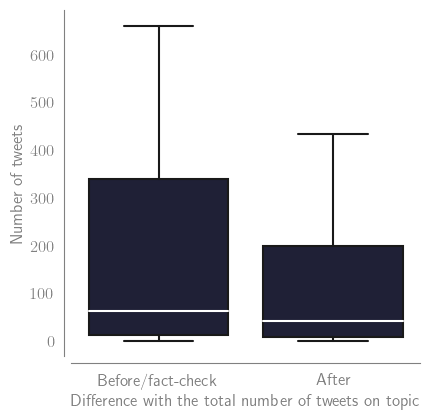

In [100]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)

sns.boxplot(impact, x='impact', y=0, order=order, showfliers=False, color=main_color, medianprops=dict(color='white'))
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.99

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-0.5, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-0.5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)

filename = f'impact_tweets_wilcoxon_hours_all'
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Difference with the total number of tweets on topic')
save_plot(fig, ax, filename,  'onclaim', legend=False)
plt.show()

### Separated test with disseminating non disseminating claims

#### Disseminating

In [101]:
impact_claim_finer = tweets_claims.groupby(['fact_id', 'impact', 'claim_finer_relation']).size().reset_index().fillna(0)   

before_disseminate = impact_claim_finer[(impact_claim_finer['impact'] == 'Before/fact-check') & (impact_claim_finer['claim_finer_relation'] == 'disseminates')]
after_disseminate = impact_claim_finer[(impact_claim_finer['impact'] == 'After') & (impact_claim_finer['claim_finer_relation'] == 'disseminates')]
#after_disseminate['fact_id'] = after_disseminate['fact_id'].astype(str)

all_facts = set(before_disseminate['fact_id']) | set(after_disseminate['fact_id'])

#fact_both = list(set(before_disseminate['fact_id']).intersection(before_disseminate['fact_id']))
print(f"Len of before_disseminate: {len(before_disseminate)}")
print(f"Len of after_disseminate: {len(after_disseminate)}")
print(f"Len of all-facts: {len(all_facts)}")

# Checking missing values in df1 and adding them to a new dataframe
missing_df1 = pd.DataFrame(columns=['fact_id', 'impact', 'claim_finer_relation', 0])
for fact_id in after_disseminate['fact_id']:
    if fact_id not in before_disseminate['fact_id'].values:
        temp = pd.DataFrame({'fact_id': fact_id,'impact': 'Before/fact-check', 'claim_finer_relation': 'disseminates', 0: 0}, index=[0])
        missing_df1 = pd.concat([missing_df1, temp], ignore_index=True)

        #missing_df1 = missing_df1.append({'fact_id': fact_id,'impact': 'Before/fact-check', 'claim_finer_relation': 'disseminates', 0: 0}, ignore_index=True)


# Checking missing values in df2 and adding them to a new dataframe
missing_df2 = pd.DataFrame(columns=['fact_id', 'impact', 'claim_finer_relation', 0])
for fact_id in before_disseminate['fact_id']:
    if fact_id not in after_disseminate['fact_id'].values:
        temp = pd.DataFrame({'fact_id': fact_id,'impact': 'After', 'claim_finer_relation': 'disseminates', 0: 0}, index=[0])
        missing_df2 = pd.concat([missing_df2, temp], ignore_index=True)

        #missing_df2 = missing_df2.append({'fact_id': fact_id,'impact': 'After', 'claim_finer_relation': 'disseminates', 0: 0}, ignore_index=True)

# Merging the original dataframes with the missing values dataframes
before_disseminate = pd.concat([before_disseminate, missing_df1], ignore_index=True)
after_disseminate = pd.concat([after_disseminate, missing_df2], ignore_index=True)

#fact_both = list(set(before_disseminate['fact_id']).intersection(before_disseminate['fact_id']))
print(f"Len of before_disseminate: {len(before_disseminate)}")
print(f"Len of after_disseminate: {len(after_disseminate)}")
print(f"Len of all-facts: {len(all_facts)}")

Len of before_disseminate: 57
Len of after_disseminate: 50
Len of all-facts: 65
Len of before_disseminate: 65
Len of after_disseminate: 65
Len of all-facts: 65


In [102]:
difference_disseminate = [a - b for a, b in zip(after_disseminate[0], before_disseminate[0])]

t, p = stats.wilcoxon(difference_disseminate)
t, p

(463.0, 0.06074706822149461)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


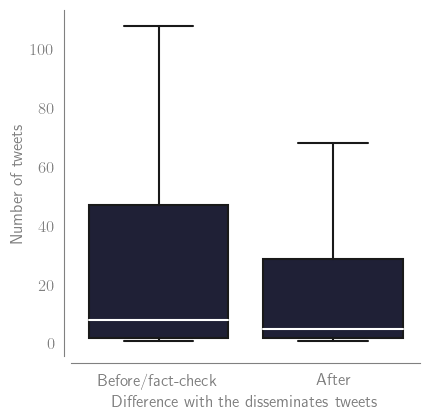

In [103]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)

sns.boxplot(impact_claim_finer[impact_claim_finer['claim_finer_relation'] == 'disseminates'], x='impact', y=0, order=order, color=main_color, medianprops=dict(color='white'), showfliers=False)
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.99

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-0.5, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-0.5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)

filename = f'impact_tweets_wilcoxon_hours_diss'
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Difference with the disseminates tweets')
save_plot(fig, ax, filename,  'onclaim', legend=False)
plt.show()

In [104]:
#### Non disseminating
impact_claim_finer = tweets_claims.groupby(['fact_id','impact', 'claim_finer_relation']).size().reset_index().fillna(0)   

before_not_disseminate = impact_claim_finer[(impact_claim_finer['impact'] == 'Before/fact-check') & (impact_claim_finer['claim_finer_relation'] == 'not-disseminates')]
after_not_disseminate = impact_claim_finer[(impact_claim_finer['impact'] == 'After') & (impact_claim_finer['claim_finer_relation'] == 'not-disseminates')]
#after_disseminate['fact_id'] = after_disseminate['fact_id'].astype(str)

all_facts = set(before_not_disseminate['fact_id']) | set(after_not_disseminate['fact_id'])

#fact_both = list(set(before_disseminate['fact_id']).intersection(before_disseminate['fact_id']))
print(f"Len of before_not_disseminate: {len(before_not_disseminate)}")
print(f"Len of after_not_disseminate: {len(after_not_disseminate)}")
print(f"Len of all-facts: {len(all_facts)}")

# Checking missing values in df1 and adding them to a new dataframe
missing_df1 = pd.DataFrame(columns=['fact_id', 'impact', 'claim_finer_relation', 0])
for fact_id in after_not_disseminate['fact_id']:
    if fact_id not in before_not_disseminate['fact_id'].values:
        temp = pd.DataFrame({'fact_id': fact_id,'impact': 'Before/fact-check', 'claim_finer_relation': 'not-disseminates', 0: 0}, index=[0])
        missing_df1 = pd.concat([missing_df1, temp], ignore_index=True)
        
# Checking missing values in df2 and adding them to a new dataframe
missing_df2 = pd.DataFrame(columns=['fact_id', 'impact', 'claim_finer_relation', 0])
for fact_id in before_not_disseminate['fact_id']:
    if fact_id not in after_not_disseminate['fact_id'].values:
        temp = pd.DataFrame({'fact_id': fact_id,'impact': 'After', 'claim_finer_relation': 'not-disseminates', 0: 0}, index=[0])
        missing_df2 = pd.concat([missing_df2, temp], ignore_index=True)


# Merging the original dataframes with the missing values dataframes
before_not_disseminate = pd.concat([before_not_disseminate, missing_df1], ignore_index=True)
after_not_disseminate = pd.concat([after_not_disseminate, missing_df2], ignore_index=True)

#fact_both = list(set(before_disseminate['fact_id']).intersection(before_disseminate['fact_id']))
print(f"Len of before_not_disseminate: {len(before_not_disseminate)}")
print(f"Len of after_not_disseminate: {len(after_not_disseminate)}")
print(f"Len of all-facts: {len(all_facts)}")

Len of before_not_disseminate: 43
Len of after_not_disseminate: 65
Len of all-facts: 68
Len of before_not_disseminate: 68
Len of after_not_disseminate: 68
Len of all-facts: 68


In [105]:
difference_not_disseminate = [a - b for a, b in zip(after_not_disseminate[0], before_not_disseminate[0])]
t, p = stats.wilcoxon(difference_not_disseminate)
t, p

(787.5, 0.1309407746682979)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


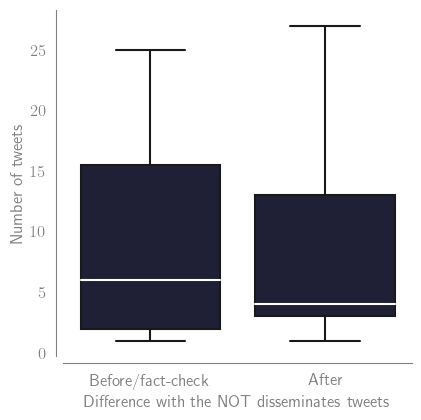

In [106]:
order = ['Before/fact-check', 'After']

sns.set_style("white")

fig, ax = plt.subplots(figsize=(6, 5))
sns.despine(offset=5, trim=False)

sns.boxplot(impact_claim_finer[impact_claim_finer['claim_finer_relation'] == 'not-disseminates'], x='impact', y=0, order=order, color=main_color, medianprops=dict(color='white'), showfliers=False)
# calculate the y position for the markers
ypos = ax.get_ylim()[1] * 0.99

# add significance markers
if p < 0.05:
    ax.plot([0.25, 0.75], [ypos, ypos], linewidth=1, color='black')
    ax.plot([0.25, 0.25], [ypos-0.5, ypos+0.05], linewidth=1, color='black')
    ax.plot([0.75, 0.75], [ypos-0.5, ypos+0.05], linewidth=1, color='black')
    ax.text(0.5, ypos, '*', ha='center', va='bottom', fontsize=20)

filename = f'impact_tweets_wilcoxon_hours_nodiss'
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Difference with the NOT disseminates tweets')
save_plot(fig, ax, filename,  'onclaim', legend=False)
plt.show()

# ITS

### On topic only

#### Data preparation

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
df_its_diss = tweets_iberifier[tweets_iberifier['claim_finer_relation'] == 'disseminates'].groupby(['diff_time', 'impact'])[['diff_time', 'impact']].mean().reset_index().rename(columns={0: 'count'})

df_its_diss['impact_int'] = np.where(df_its_diss['impact'] == 'Before/fact-check', 0, 1)
#df_its_diss['claim_finer_relation_int'] = np.where(df_its_diss['claim_finer_relation'] == 'disseminates', 0, 1)
df_its_diss.set_index('diff_time', inplace=True)

In [ ]:
pre_fact = df_its_diss.loc[df_its_diss.index < 0]
post_fact = df_its_diss.loc[df_its_diss.index > 0]
post_fact

#### Checking for stationary

In [ ]:
# Calculate and plot the rolling mean and rolling standard deviation
rolling_mean = df_its_diss['count'].rolling(window=12).mean()
rolling_std = df_its_diss['count'].rolling(window=12).std()

plt.plot(df_its_diss.index, df_its_diss['count'], label='Original')
plt.plot(df_its_diss.index, rolling_mean, label='Rolling Mean')
plt.plot(df_its_diss.index, rolling_std, label='Rolling Std')
plt.xlabel('Hours')
plt.ylabel('count')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()


In [ ]:

result = adfuller(df_its_diss['count'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


In [ ]:
# Not stationary need to transform the data
## Method 1 Differencing
differenced_ts = df_its_diss['count'].diff().dropna().reset_index()  # First-order differencing
differenced_ts

In [ ]:
# Calculate and plot the rolling mean and rolling standard deviation
rolling_mean = differenced_ts['count'].rolling(window=12).mean()
rolling_std = differenced_ts['count'].rolling(window=12).std()

plt.plot(differenced_ts.index, differenced_ts['count'], label='Original')
plt.plot(differenced_ts.index, rolling_mean, label='Rolling Mean')
plt.plot(differenced_ts.index, rolling_std, label='Rolling Std')
plt.xlabel('Hours')
plt.ylabel('count')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

In [ ]:
result = adfuller(differenced_ts['count'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


In [ ]:
# Determining ARIMA order (p, d, q)
plot_acf(differenced_ts['count'], lags=20)



In [ ]:
plot_pacf(differenced_ts['count'], lags=20)

#### Fitting the model

In [ ]:
model = ARIMA((pre_intervention['count'], exog=exog.loc[pre_intervention.index], order=(p, d, q))  # Replace p, d, q with appropriate ARIMA parameters

### GLM Model

In [ ]:
# Extracting the variables
df_model = tweets_iberifier[['fact_id', 'fact_checker', 'diff_time', 'claim_relation', 'impact']]
# Getting the count of the fact_ids
grouped_df = df_model.groupby(['fact_id']).size()
# Resetting the index
grouped_df = grouped_df.reset_index()
# Merging them to add the count to each fact_id
merged_df = pd.merge(df_model, grouped_df, on='fact_id')
merged_df.rename(columns={0:'counts'}, inplace=True)
merged_df['diff_time'] = merged_df['diff_time'].fillna(0).astype(int)
merged_df['impact'] = merged_df['impact'].apply(lambda x: 1 if x == 'After' else 0)
merged_df['claim_relation'] = merged_df['impact'].apply(lambda x: 1 if x == 'disseminates' else 0)


In [ ]:
### Fitting the models

formula = 'counts ~ impact + diff_time  + claim_relation'

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the GLM with negative binomial distribution
model = smf.glm(formula=formula, data=merged_df, family=sm.families.NegativeBinomial()).fit()

# Print the model summary
print(model.summary())

In [ ]:
from pymer4.models import Lmer

# Initialize model instance using 1 predictor with random intercepts and slopes
model = Lmer("counts ~ impact + claim_relation | (fact_id)", data=merged_df)

# Fit it
print(model.fit())

In [ ]:
model.__dict__